Celem laboratorium było wykonanie testów porównujących działanie oraz wydajność implementacji własnych wraz z implementacjami z bibliotek dla SVM oraz MLP.
SVM miało być porównane jako własna implementacja z regresją liniową jako pakietem z biblioteki `scikit-learn`.
Własne implementacje MLP jako backpropagation oraz MlpExtreme również miały być se sobą porównane.

Importy:

In [1]:
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import cvxopt as cvx
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import time

E:\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Poniżej implementacja klasy abstrakcyjnej będącej bazą dla pozostałych klasyfikatorów.

Opis niepodpisanych parametrów:
* `class_labels_` - unikalne nazwy klas
* `max_seconds` - właściwość określający po jakim czasie uczenie powinno zostać przerwane. Wykorzystywane szczególnie w przypadku implementacji funkcji `fit` w perceptronach
* `iteration_count` - właściwość obiektu służąca do przechowywania liczby wykonanych iteracji w trakcie uczenia. Używane szczególnie w przypadku implementacji funkcji `fit` dla perceptronów

Opis metod:
* `fit` - abstrakcyjna metoda przyjmująca dane jako `x` oraz decyzje jako `d`
* `margin` - metoda wyznaczająca margines separacji pomiędzy nauczonymi danymi
* `plot_class` - metoda wizualizująca podział danych z wykorzystaniem albo linii separucjącej albo konturów
* `plot_class_universal` - statyczna wersja metody `plot_class`, która przyjmuje dowolny klasyfikator spełniający założenia szablonu klasyfikatorów liniowych z biblioteki `scikit-learn`

In [2]:
class LinearClassifier(ABC):
    def __init__(self, coefs=None, intercepts=None, class_labels=None, max_seconds: int = 3600):
        self.coef_ = coefs  # w
        self.intercept_ = intercepts  # b
        self.class_labels_ = class_labels

        self.max_seconds = max_seconds
        self.iteration_count = 0

    @abstractmethod
    def fit(self, x, d):
        ...

    def margin(self, x, d, distance: bool = False):
        # margines w danych to jest minimum z wektora. jak margines jest dodatni, to znaczy, że jest separowalne
        margin = (x.dot(self.coef_) + self.intercept_) * d
        if distance:
            margin /= np.linalg.norm(self.coef_)

        return margin

    def decision_function(self, x: np.array):
        return self.margin(x, np.ones(x.shape[0]))

    def predict_proba(self, x: np.array):
        a, b = self.margin(x, np.ones((x.shape[0], )))
        i = 1 - 1 / (1 + np.exp(-b))
        j = 1 / (1 + np.exp(-b))

        return np.array([i, j]).T

    def predict(self, x: np.array):
        results = np.sign(x.dot(self.coef_) + self.intercept_)
        results_mapped = self.class_labels_[1 * (results > 0)] if self.class_labels_ is not None else results

        return results_mapped

    def get_params(self, deep=True):
        pass

    def set_params(self, **parameters):
        pass

    def __str__(self):
        return f'{self.__class__.__name__}'

    def plot_class(self, x, y, is_line: bool = False, support_vectors: np.array = None, dataset_title: str = None):
        self.plot_class_universal(self, x, y, is_line, support_vectors, dataset_title)

    @staticmethod
    def plot_class_universal(clf, x, y, is_line: bool = False, support_vectors: np.array = None, dataset_title: str = None):
        x1_min = np.min(x[:, 0]) - 0.5
        x1_max = np.max(x[:, 0]) + 0.5

        plt.figure(figsize=(20, 10))

        if is_line:
            points = np.array([[i, -(clf.coef_[0] * i + clf.intercept_) / clf.coef_[1]] for i in np.linspace(x1_min, x1_max)])
            plt.plot(points[:, 0], points[:, 1], 'k')
        else:
            x2_min = np.min(x[:, 1]) - 0.5
            x2_max = np.max(x[:, 1]) + 0.5

            number_of_points = 250
            xn, yn = np.meshgrid(np.linspace(x1_min, x1_max, number_of_points), np.linspace(x2_min, x2_max, number_of_points))
            zn = clf.predict(np.c_[xn.flatten(), yn.flatten()]).reshape(xn.shape)

            plt.contourf(xn, yn, zn, cmap=ListedColormap(['y', 'r']))

        if support_vectors is not None:
            plt.plot(x[support_vectors, 0], x[support_vectors, 1], 'co', markersize=10, alpha=0.5)

        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['b', 'g']))

        dataset_title = f'for {dataset_title} dataset' if dataset_title else ''
        plt.title(f'{clf} - Boundary of separation {dataset_title}')

        plt.show()

Poniżej reprezentacja klasy implementującej SVM.

Opis parametrów:
* `c_` - parametr regularyzacyjny
* `sv_indexes_` - indeksy próbek podpierających

In [3]:
class Svm2(LinearClassifier):
    def __init__(self, c: float = 1.0, cls_lab=None):
        super().__init__(cls_lab)

        self.c_ = c
        self.sv_indexes_ = None

    def fit(self, x: np.array, y: np.array):
        m, n = x.shape

        gp = -np.hstack((np.outer(y, np.ones(n + 1)) * np.hstack((x, np.ones((m, 1)))), np.eye(m)))
        gpp = np.hstack((np.zeros((m, n + 1)), -np.eye(m)))
        g = cvx.matrix(np.vstack((gp, gpp)))

        h = cvx.matrix(np.concatenate((np.ones(m) * -1, np.zeros(m))))
        p = cvx.matrix(np.diag(np.concatenate((np.ones(n), np.zeros(m + 1)))))
        q = cvx.matrix(np.concatenate((np.zeros(n + 1), self.c_ * np.ones(m))))

        solution = cvx.solvers.qp(p, q, g, h)

        # print(g, h, p, q)
        # [print(k, ':', v) for k, v in solution.items()]

        self.coef_ = solution['x'][:n]
        self.intercept_ = solution['x'][n]
        self.sv_indexes_ = np.nonzero(np.array(solution['z'][:n]) > 10e-5)[0]

    def __str__(self):
        return f'SVM2(c={self.c_})'

Poniżej reprezantacja implementacji klasy do wykonywania eksperymentów związanych z SVM.
Testy przedstawiają działanie własnej implementacji SVM poprzez klasę `SVM2`, implementacji SVM z biblioteki `scikit-learn` oraz implementacji regresji liniowej również z biblioteki `scikit-learn`.
Główna metoda `experiment` jest odpowiedzialna za uruchomienie eksperymentów dla wszystkich implementacji w wykorzystaniem liniowo separowalnego, liniowo nieseparowalnego zbioru danych oraz zbioru danych 'sonar'.

In [11]:
class SvmTest:
    def __init__(self, c: float = 1e-3):
        self.c_ = c

    def experiment(self):
        sonar_data = pd.read_csv('E:\Programowanie\Python\computational-intelligence\machine-learning-1\zad4\sonar_csv.csv')
        sonar_y = self.normalize_decisions(sonar_data[sonar_data.columns[-1]])
        sonar_x = sonar_data.drop(sonar_data.columns[-1], axis=1).to_numpy()

        datasets = {
            'linear_non_separable': self.generate_linear_non_separable_dataset(),
            'sonar': [sonar_x, sonar_y],
        }

        for title, dataset in datasets.items():
            print(f'\n------ Dataset {title} ------')
            x, y = dataset

            for method in [self.svm_my_experiment, self.svm_sklearn_experiment, self.logistic_regression_sklearn_experiment]:
                print()
                method(x, y, title)

    def svm_my_experiment(self, x: np.array, y: np.array, dataset_title: str):
        svm2 = Svm2(c=self.c_)

        self.fit_measure(svm2, x, y)
        self.predict_measure_and_visualise(svm2, x, y, dataset_title)

        print(f'Separation margin for {svm2}: {svm2.margin(x, y)}')
        print(f'Support vectors for {svm2}\n{svm2.sv_indexes_}')

    def svm_sklearn_experiment(self, x: np.array, y: np.array, dataset_title: str):
        svc = SVC(C=self.c_)
        self.fit_measure(svc, x, y)
        self.predict_measure_and_visualise(svc, x, y, dataset_title)

        print(f'Support vectors for {svc}\n{svc.support_vectors_}')

    def logistic_regression_sklearn_experiment(self, x: np.array, y: np.array, dataset_title: str):
        linear_regression = LogisticRegression(C=self.c_)
        self.fit_measure(linear_regression, x, y)
        self.predict_measure_and_visualise(linear_regression, x, y, dataset_title)

    @staticmethod
    def fit_measure(clf, x, y):
        t1 = time.time()
        clf.fit(x, y)
        t2 = time.time()
        print(f'Time of fitting for {clf}: {t2 - t1}s')

    @staticmethod
    def predict_measure_and_visualise(clf, x, y, dataset_title: str):
        t1 = time.time()
        clf.predict(x) if dataset_title == 'sonar' else LinearClassifier.plot_class_universal(clf, x, y, dataset_title=dataset_title)
        t2 = time.time()
        print(f'Time of plotting with predicting for {clf}: {t2 - t1}s')

    @staticmethod
    def generate_simple_separable_dataset():
        x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
        y = np.array([-1, -1, -1, 1])

        return [x, y]

    @staticmethod
    def generate_linear_separable_dataset(n: int = 1000):
        w, b = [1, 1], -1
        x = np.random.randn(n, 2)
        d = np.sign(x.dot(w) + b)

        return [x, d]

    @staticmethod
    def generate_linear_non_separable_dataset(n: int = 1000):
        x = np.vstack((np.random.randn(n, 2), np.random.randn(n, 2) + 2))
        y = np.concatenate((np.ones(n), -np.ones(n)))

        return [x, y]

    @staticmethod
    def normalize_decisions(d):
        d_normalized = np.ones(d.shape[0]).astype("int8")
        d_normalized[d == np.unique(d)[0]] = -1

        return d_normalized

Poniżej klasa reprezentująca implementację wersji MLP jako Extreme.
Implementacja zakłada jedną warstę ukrytą.

Opis parametrów:
* `clf_lin` - dowolny klasyfikator liniowy używany do uczenia oraz predykcji
* `neurons_hidden_count` - liczba neuronów w warstwie ukrytej
* `w1` - wagi warstwy wejściowej
* `b1` - wartości odchylenia warsty wejściowej

In [5]:
class MlpExtreme(LinearClassifier):
    def __init__(self, clf_lin, neurons_hidden_count: int = 100):
        super().__init__()

        self.clf_lin = clf_lin  # można wstawić za klasyfikator liniowy SVM
        self.neurons_hidden_count = neurons_hidden_count

        self.w1 = None
        self.b1 = None

    def fit(self, x: np.array, d: np.array):
        self.w1 = np.zeros((x.shape[1], self.neurons_hidden_count))  # wagi warstry wejściowej, wyznaczyć losując
        self.b1 = np.zeros(self.neurons_hidden_count)  # wartości odchylenia warstry wejściowej, wyznaczyć losując

        for i in range(self.neurons_hidden_count):
            i1, i2 = np.random.choice(x.shape[0], 2)
            xi, xj = x[i1, :], x[i2, :]

            self.w1[:, i] = (xi - xj).T
            self.b1[i] = (-self.w1[:, i].dot(xi.T))  # chcemy dodać b do każdej kolumny

        v = self.sigmoid(x.dot(self.w1) + self.b1)
        # v = self.sigmoid(self.w1.T.dot(x) + self.b1)
        self.clf_lin.fit(v, d)  # dowolny klasyfikator liniowy posiadający fit

        self.coef_ = self.clf_lin.coef_
        self.intercept_ = self.clf_lin.intercept_

    def predict(self, x: np.array):
        v = self.sigmoid(x.dot(self.w1) + self.b1)

        return self.clf_lin.predict(v)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def __str__(self):
        return f'MlpExtreme(clf_lin={self.clf_lin}, neurons_hidden_count={self.neurons_hidden_count})'

Poniżej klasa reprezentująca implementację back propagation MLP z jedną warstwą ukrytą.

Opis parametrów:
* `neurons_hidden_count` - liczba neuronów w warstwie ukrytej
* `max_iter` - maksymalna liczba iteracji wykonywania algorytmu dopasowania (uczenia)
* `alpha` - parametr regularyzacyjny
* `shuffle` - parametr określający czy mieszać próbki uczące co iterację. Mieszanie próbek uczących przyspiesza uczenie
* `weights_scale` - mnożnik dla wag, który zmniejsza ich wartości do bardzo małych
* `hidden_weights` - wektor wag pomiędzy warstwą wejściową a warstwą ukrytą
* `hidden_biases` - wartości odchyleń pomiędzy warstwą wejściową a warstwą ukrytą

Opis metod: 
* `fit` - metoda dopasowująca model do próbek uczących. Przygotowuje ona wektory wag oraz wektory wartości odchyleń oraz wykonuje iteracje aż do `max_iter`.
* `forward_propagation` - wykonuje propagację wprzód, krok do przodu. Wylicza wartości aktywacji dla warstw ukrytej oraz wyjściowej
* `back_propagation` - wykonuje krok w tył, wsteczna propagacja. Wylicza delty oraz gradienty jako wartości poprawek dla warstw ukrytej oraz wyjściowej
* `update_weights` - wykonuje poprawki wag oraz wartości odchyleń
* `sigmoid` - funkcja aktywacji
* `normalize_decisions` - normalizuje decyzje, aby reprezentowane one były przez dwie klasy: -1 oraz 1

In [6]:
class MlpBackPropagation(LinearClassifier):
    def __init__(self, neurons_hidden_count: int = 100, max_iter: int = 1000, alpha: float = 0.01, shuffle: bool = False):
        super().__init__()

        self.neurons_hidden_count = neurons_hidden_count
        self.max_iter = max_iter
        self.alpha = alpha
        self.shuffle = shuffle

        self.weights_scale = 10 ** -3

        self.hidden_weights = None
        self.hidden_biases = None

    def fit(self, x: np.array, d: np.array) -> None:
        y = self.normalize_decisions(d, x)
        self.class_labels_ = np.unique(y)

        self.hidden_weights = np.random.normal(size=(x.shape[1], self.neurons_hidden_count))
        self.hidden_biases = np.random.normal(size=self.neurons_hidden_count)

        self.coef_ = np.random.normal(size=(self.neurons_hidden_count, y.shape[1]))
        self.intercept_ = np.random.normal(size=y.shape[1])

        for _ in range(self.max_iter):
            if self.shuffle:
                np.random.shuffle(x)

            for x_iter, x_val in enumerate(x):
                params_activations = self.forward_propagation(x_val)
                params_fixes = self.back_propagation(x_val, y[x_iter], params_activations)
                self.update_weights(params_fixes)

    def forward_propagation(self, x: np.array) -> list:
        z1 = x.dot(self.hidden_weights) + self.hidden_biases  # neuron value at hidden layer
        a1 = self.sigmoid(z1)  # activation value at output layer
        z2 = a1.dot(self.coef_) + self.intercept_  # neuron value at output layer
        a2 = self.sigmoid(z2)  # activation value at output layer

        return [a1, a2]

    def back_propagation(self, x: np.array, d: np.array, params: list) -> dict:
        a1, a2 = params

        delta_out = (a2 - d) * (a2 * (1 - a2))
        gradient_out = np.outer(a1, delta_out)

        delta_hidden = np.dot(delta_out, self.coef_.T) * (a1 * (1 - a1))
        gradient_hidden = np.outer(x, delta_hidden)

        return {'delta_out': delta_out, 'gradient_out': gradient_out, 'delta_hidden': delta_hidden, 'gradient_hidden': gradient_hidden}

    def update_weights(self, params: dict) -> None:
        self.hidden_weights -= self.alpha * params['gradient_hidden']
        self.hidden_biases -= self.alpha * params['delta_hidden']
        self.coef_ -= self.alpha * params['gradient_out']
        self.intercept_ -= self.alpha * params['delta_out']

    def predict(self, x: np.array) -> np.array:
        a2 = self.forward_propagation(x)[-1]
        if len(a2.shape) == 1:
            return self.class_labels_[np.argmax(a2)]

        return np.array([self.class_labels_[np.argmax(pair)] for pair in a2])

    @staticmethod
    def sigmoid(x) -> np.array:
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def normalize_decisions(d: np.array, x: np.array) -> np.array:
        classes = np.unique(d)
        y = np.full((x.shape[0], classes.shape[0]), 0)

        for i in range(x.shape[0]):
            y[i, np.where(classes == d[i])[0]] = 1

        return y

    def __str__(self) -> str:
        return f'MlpBackPropagation(neurons_hidden_count={self.neurons_hidden_count}, max_iter={self.max_iter}, alpha={self.alpha}, shuffle={self.shuffle})'

Poniżej reprezantacja implementacji klasy do wykonywania eksperymentów związanych z MLP.
Testy przedstawiają działanie własnej implementacji dla MLP BackPropagation, MLP Extreme oraz dla implemetacji `MlpClassifier` istniejącej w bibliotece `scikit-learn`.
Wersja MLP Extreme wykorzystuje klasyfikator liniowy SVM jako własną implementację `SVM2`.

Opis parametrów:
* `layers` - liczba warstw ukrytych
* `neurons_count_in_one_hidden_layer` - liczba neuronów w jednej warstwie ukrytej
* `train_data_size` - rozmiar danych uczących względem całego zbioru danych
* `alpha` - parametr regularyzacyjny

Główna metoda `experiment` uruchamia eksperymenty dla wszystkich wymienionych wyżej klasyfikatorach stosując kombinację wszystkich permutacji opisanych powyżej parametrów.
Zbiory danych generowane na potrzeby eksperymentów to szachownica, zagnieżdżone okręgi oraz zagnieżdżone spirale.

In [20]:
class MlpTest:
    def __init__(self):
        self.layers = [1]
        self.neurons_count_in_one_hidden_layer = [100, 300, 1000]
        self.train_data_size = [0.5, 0.6, 0.8]
        self.alpha = [10 ** i for i in range(-3, -1)]

    def experiment(self):
        datasets_n = [1000, 10000, 100000]

        for n in datasets_n:
            experiment_datasets = {
                'circles': self.generate_circles_dataset(n),
                'spirals': self.generate_spirals_dataset(n),
                'chessboard': self.generate_chessboard_dataset(n),
            }

            for title, (x, y) in experiment_datasets.items():
                self.dataset_experiment((f'{title}_n_{n}', x, y))

    def dataset_experiment(self, dataset: tuple):
        for layers in self.layers:
            for neurons_count_in_one_hidden_layer in self.neurons_count_in_one_hidden_layer:
                for train_data_size in self.train_data_size:
                    neurons = tuple([neurons_count_in_one_hidden_layer for _ in range(layers)])

                    for alpha in self.alpha:
                        self.mlp_experiment(neurons, train_data_size, alpha, dataset)

    def mlp_experiment(self, neurons_in_hidden_layers: tuple, train_data_size: float, alpha: float, dataset: tuple):
        dataset_title, x, y = dataset
        dataset_title += f'_train_size_{train_data_size}'
        divided_train_test = train_test_split(x, y, train_size=train_data_size, random_state=0)

        for method in [self.mlp_sklearn_experiment, self.mlp_backprop_experiment, self.mlp_extreme_experiment]:
            print('')
            method(neurons_in_hidden_layers, divided_train_test, alpha, dataset_title)

    def mlp_sklearn_experiment(self, neurons_in_hidden_layers, divided_train_test: tuple, alpha: float, dataset_title: str):
        mlp = MLPClassifier(neurons_in_hidden_layers, alpha=alpha, max_iter=1000)
        self.experiment_for_specific_mlp(mlp, divided_train_test, dataset_title)

    def mlp_backprop_experiment(self, neurons_in_hidden_layers: tuple, divided_train_test: tuple, alpha: float, dataset_title: str):
        mlp = MlpBackPropagation(neurons_in_hidden_layers[0], max_iter=1000, alpha=alpha)
        self.experiment_for_specific_mlp(mlp, divided_train_test, dataset_title)

    def mlp_extreme_experiment(self, neurons_in_hidden_layers: tuple, divided_train_test: tuple, alpha: float, dataset_title: str):
        mlp = MlpExtreme(LogisticRegression(max_iter=1000), neurons_in_hidden_layers[0])
        self.experiment_for_specific_mlp(mlp, divided_train_test, dataset_title)

    def experiment_for_specific_mlp(self, mlp, divided_train_test: tuple, dataset_title: str):
        x_train, x_test, y_train, y_test = divided_train_test

        t1 = time.time()
        mlp.fit(x_train, y_train)
        t2 = time.time()
        print(f'Time of fitting on {dataset_title} for {mlp}: {t2 - t1}s')

        self.classification_quality(mlp, x_train, y_train, 'train')
        self.classification_quality(mlp, x_test, y_test, 'test')

        LinearClassifier.plot_class_universal(mlp, x_test, y_test, dataset_title=dataset_title)

    @staticmethod
    def classification_quality(mlp, x: np.array, y: np.array, classification_type: str = 'test'):
        t1 = time.time()
        y_pred = mlp.predict(x)
        t2 = time.time()
        print(f'Time of {mlp} prediction for {classification_type} data: {t2 - t1}s')

        print(f'Metrics of {mlp} for {classification_type}:')
        accuracy = metrics.accuracy_score(y, y_pred)
        print(f'\tAccuracy: {accuracy}')

        f1_score = metrics.f1_score(y, y_pred)
        print(f'\tF1: {f1_score}')

        auc_score = metrics.roc_auc_score(y, y_pred)
        print(f'\tAUC: {auc_score}')

    @staticmethod
    def generate_chessboard_dataset(n: int = 1000, m: int = 3):
        x = np.random.rand(n, 2) * m
        y = np.mod(np.sum(np.floor(x), axis=1), 2) * 2. - 1.
        x = x + np.random.randn(*x.shape) * 0.1

        return x, y

    @staticmethod
    def generate_circles_dataset(n: int = 1000):
        x, y = datasets.make_circles(n)

        return x, y

    @staticmethod
    def generate_spirals_dataset(n: int = 100, noise: float = 0.1, length: int = 2):
        t = np.linspace(0, (2 * np.pi * length) ** 2, n // 2)
        t = t ** 0.5

        x1 = (0.2 + t) * np.cos(t)
        y1 = (0.2 + t) * np.sin(t)
        x2 = (0.2 + t) * np.cos(t + np.pi)
        y2 = (0.2 + t) * np.sin(t + np.pi)

        x = np.array([np.concatenate((x1, x2)), np.concatenate((y1, y2))]).T + np.random.randn(n, 2) * noise
        y = np.concatenate((-np.ones(n // 2), +np.ones(n // 2)))
        p = np.random.permutation(n)

        x = x[p, :]
        y = y[p]

        return x, y

Wykonanie eksperymentów dla części związanej z SVM:


------ Dataset linear_non_separable ------

     pcost       dcost       gap    pres   dres
 0:  4.3992e-01  3.3565e+02  2e+04  3e+00  6e+03
 1:  4.4743e+00 -1.6487e+02  2e+02  3e-02  6e+01
 2:  4.2912e+00 -4.4501e+00  9e+00  9e-04  2e+00
 3:  1.8202e+00  5.6984e-01  1e+00  5e-16  9e-16
 4:  8.9655e-01  7.0675e-01  2e-01  3e-16  3e-16
 5:  8.2033e-01  7.8679e-01  3e-02  2e-16  2e-16
 6:  8.0714e-01  8.0077e-01  6e-03  2e-16  3e-16
 7:  8.0510e-01  8.0283e-01  2e-03  2e-16  3e-16
 8:  8.0423e-01  8.0369e-01  5e-04  2e-16  1e-15
 9:  8.0402e-01  8.0391e-01  1e-04  2e-16  1e-15
10:  8.0396e-01  8.0396e-01  5e-06  2e-16  1e-15
11:  8.0396e-01  8.0396e-01  5e-08  2e-16  1e-14
Optimal solution found.
Time of fitting for SVM2(c=0.001): 4.989012241363525s


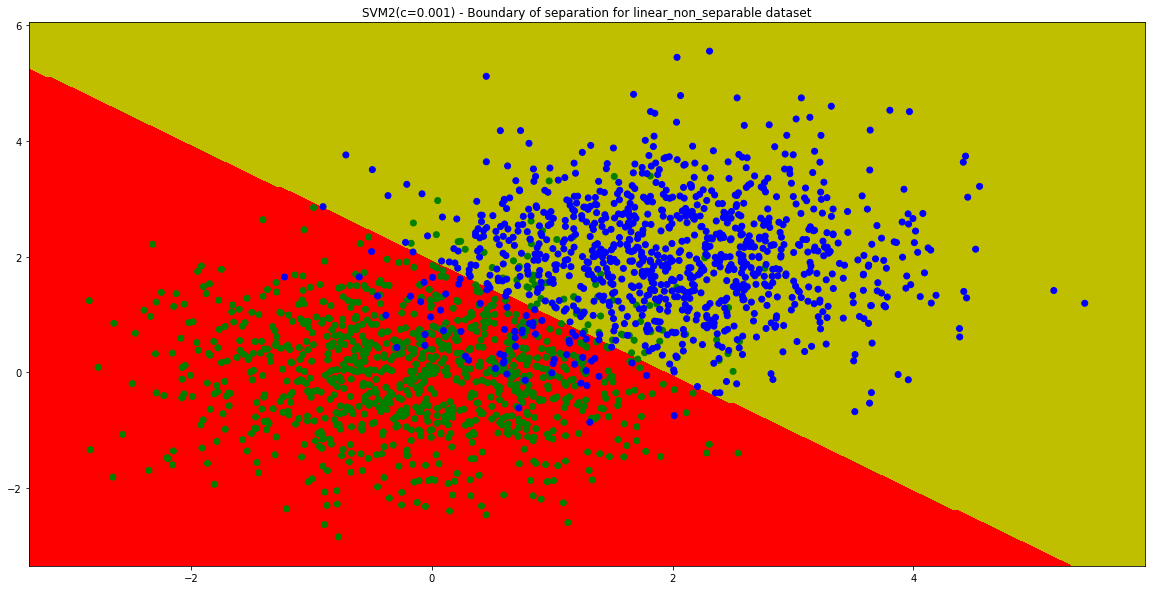

Time of plotting with predicting for SVM2(c=0.001): 0.19657540321350098s
Separation margin for SVM2(c=0.001): [[ 1.24863358  1.24863358  1.24863358 ... -1.24863358 -1.24863358
  -1.24863358]
 [ 2.69737693  2.69737693  2.69737693 ... -2.69737693 -2.69737693
  -2.69737693]
 [ 1.02453597  1.02453597  1.02453597 ... -1.02453597 -1.02453597
  -1.02453597]
 ...
 [-3.07794335 -3.07794335 -3.07794335 ...  3.07794335  3.07794335
   3.07794335]
 [-1.33610615 -1.33610615 -1.33610615 ...  1.33610615  1.33610615
   1.33610615]
 [-1.73926304 -1.73926304 -1.73926304 ...  1.73926304  1.73926304
   1.73926304]]
Support vectors for SVM2(c=0.001)
[]

Time of fitting for SVC(C=0.001): 0.13297677040100098s


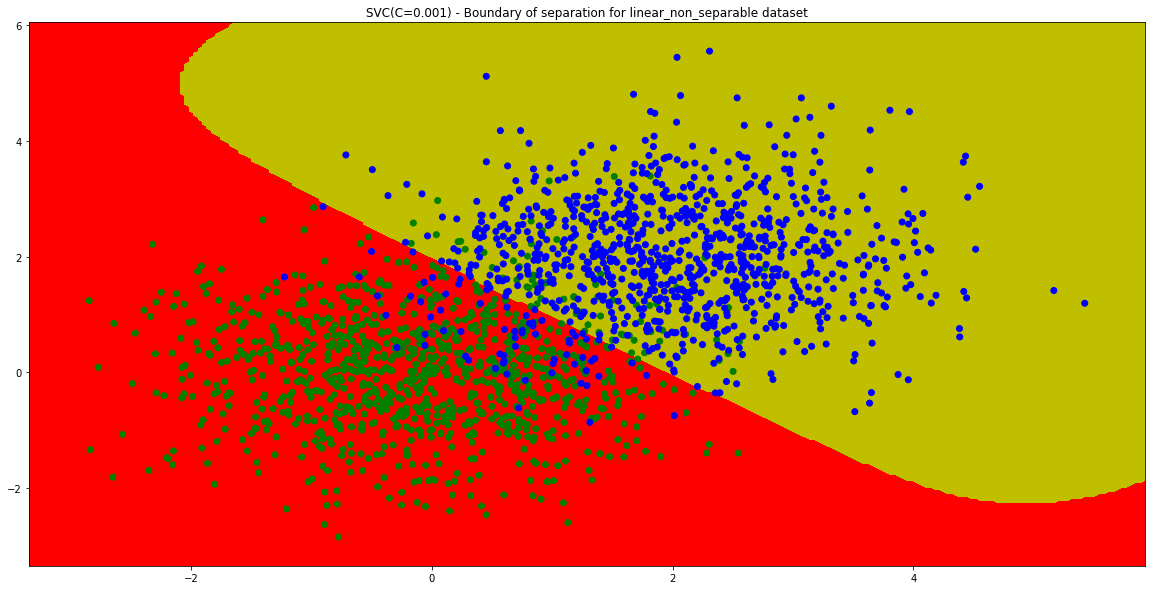

Time of plotting with predicting for SVC(C=0.001): 11.683568000793457s
Support vectors for SVC(C=0.001)
[[ 1.4373467   2.07972263]
 [ 1.47218855  1.21206588]
 [ 3.12402869  1.22979975]
 ...
 [-0.89160017 -2.62881452]
 [ 0.65018619  0.35929834]
 [-0.63539319  0.19633081]]

Time of fitting for LogisticRegression(C=0.001): 0.0068111419677734375s


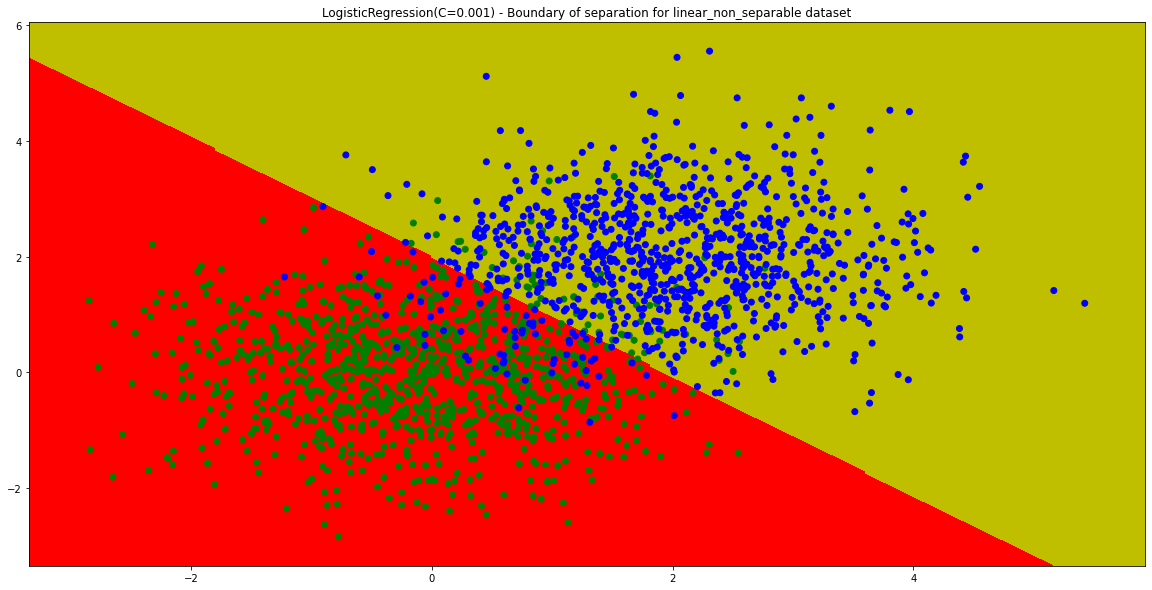

Time of plotting with predicting for LogisticRegression(C=0.001): 0.20412015914916992s

------ Dataset sonar ------

     pcost       dcost       gap    pres   dres
 0:  3.0818e+00  6.0370e+01  2e+03  3e+00  1e+02
 1:  1.6140e+00 -7.1230e+01  8e+01  1e-01  8e+00
 2:  5.5130e-01 -5.5438e+00  6e+00  1e-02  6e-01
 3:  4.8611e-01  1.6277e-01  3e-01  1e-15  5e-16
 4:  2.3177e-01  1.8312e-01  5e-02  6e-16  8e-17
 5:  1.9783e-01  1.9289e-01  5e-03  4e-16  6e-16
 6:  1.9423e-01  1.9303e-01  1e-03  3e-16  9e-16
 7:  1.9422e-01  1.9306e-01  1e-03  4e-16  8e-16
 8:  1.9392e-01  1.9314e-01  8e-04  4e-16  7e-16
 9:  1.9363e-01  1.9322e-01  4e-04  3e-16  6e-16
10:  1.9347e-01  1.9329e-01  2e-04  3e-16  1e-15
11:  1.9337e-01  1.9334e-01  3e-05  4e-16  1e-15
12:  1.9336e-01  1.9335e-01  7e-06  4e-16  6e-16
13:  1.9336e-01  1.9335e-01  1e-06  4e-16  1e-15
14:  1.9335e-01  1.9335e-01  2e-08  4e-16  1e-15
Optimal solution found.
Time of fitting for SVM2(c=0.001): 0.08581948280334473s
Time of plotting wit

In [12]:
svm_test = SvmTest()
svm_test.experiment()

Wykonanie eksperymentów dla części związanej z MLP:


Time of fitting on circles_n_1000_train_size_0.5 for MLPClassifier(alpha=0.001, max_iter=1000): 2.1360878944396973s
Time of MLPClassifier(alpha=0.001, max_iter=1000) prediction for train data: 0.0009891986846923828s
Metrics of MLPClassifier(alpha=0.001, max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, max_iter=1000) prediction for test data: 0.0s
Metrics of MLPClassifier(alpha=0.001, max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


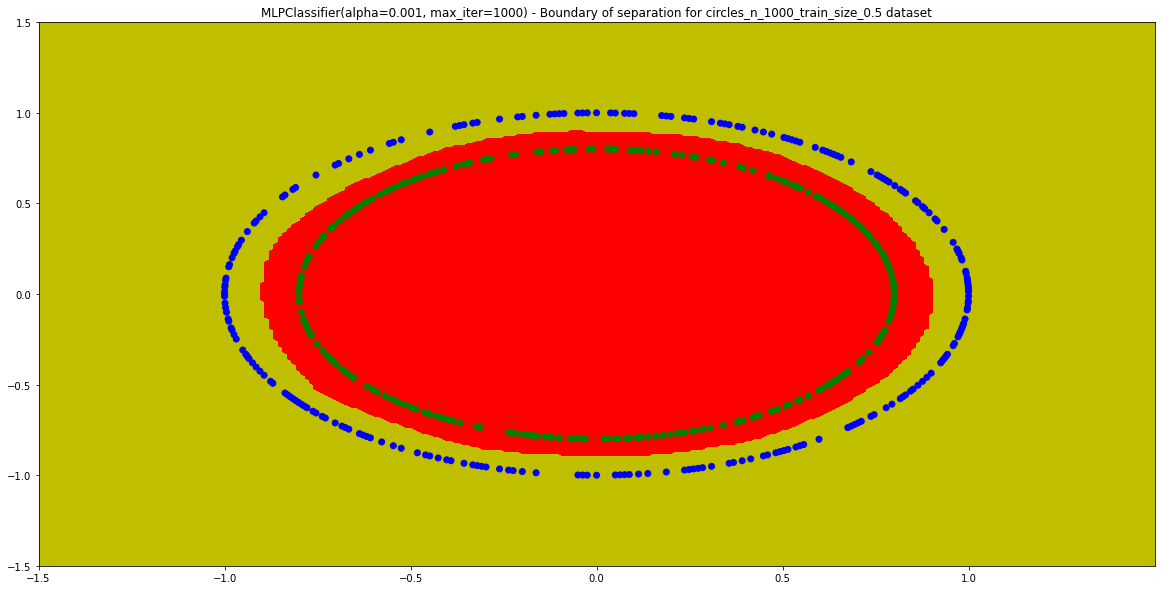


Time of fitting on circles_n_1000_train_size_0.5 for MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False): 24.419944047927856s
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) prediction for train data: 0.003010988235473633s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) prediction for test data: 0.0019965171813964844s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


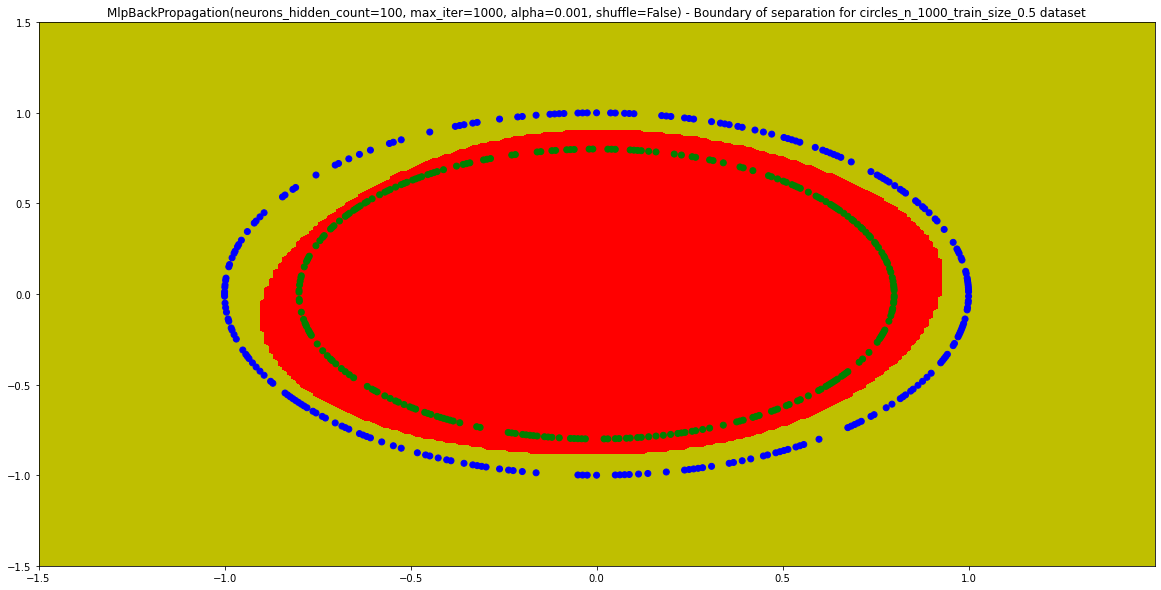


Time of fitting on circles_n_1000_train_size_0.5 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100): 0.035523176193237305s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for train data: 0.0010013580322265625s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for test data: 0.0025451183319091797s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


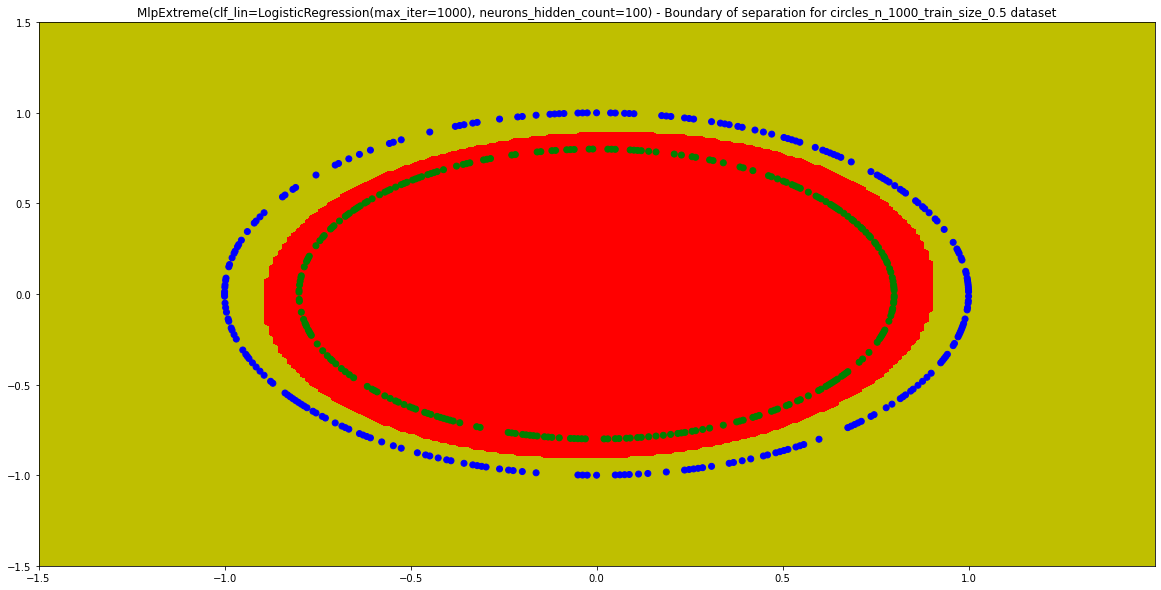


Time of fitting on circles_n_1000_train_size_0.5 for MLPClassifier(alpha=0.01, max_iter=1000): 2.1438677310943604s
Time of MLPClassifier(alpha=0.01, max_iter=1000) prediction for train data: 0.0009305477142333984s
Metrics of MLPClassifier(alpha=0.01, max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.01, max_iter=1000) prediction for test data: 0.0s
Metrics of MLPClassifier(alpha=0.01, max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


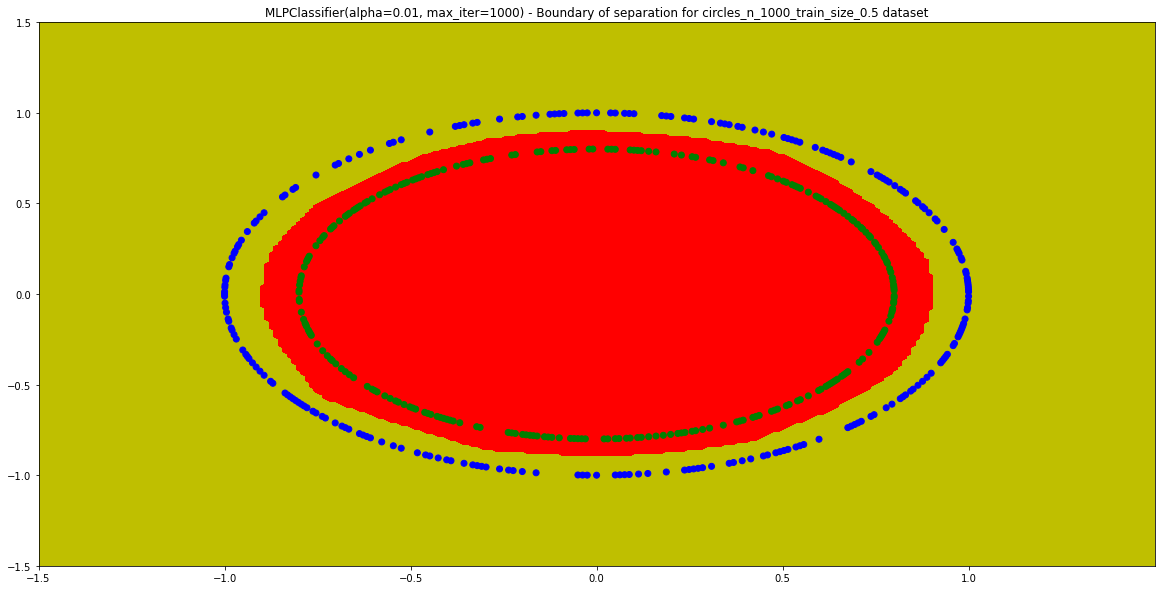


Time of fitting on circles_n_1000_train_size_0.5 for MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False): 24.32201385498047s
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) prediction for train data: 0.002997159957885742s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) prediction for test data: 0.001998424530029297s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


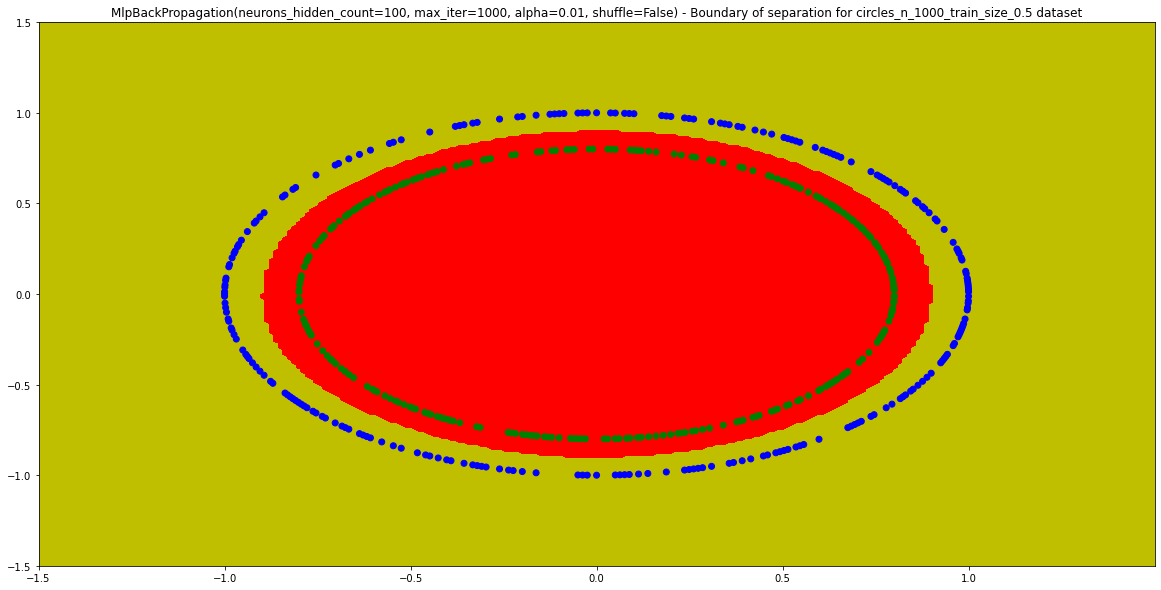


Time of fitting on circles_n_1000_train_size_0.5 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100): 0.040993452072143555s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for train data: 0.0009953975677490234s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for test data: 0.00099945068359375s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


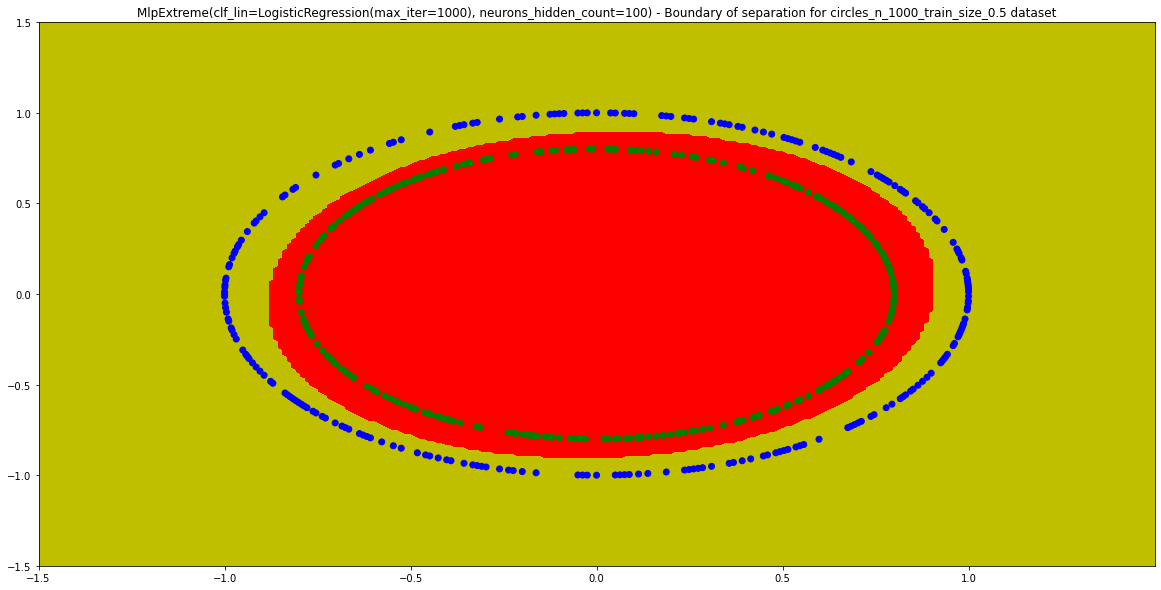


Time of fitting on circles_n_1000_train_size_0.6 for MLPClassifier(alpha=0.001, max_iter=1000): 2.147428512573242s
Time of MLPClassifier(alpha=0.001, max_iter=1000) prediction for train data: 0.00099945068359375s
Metrics of MLPClassifier(alpha=0.001, max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, max_iter=1000) prediction for test data: 0.0s
Metrics of MLPClassifier(alpha=0.001, max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


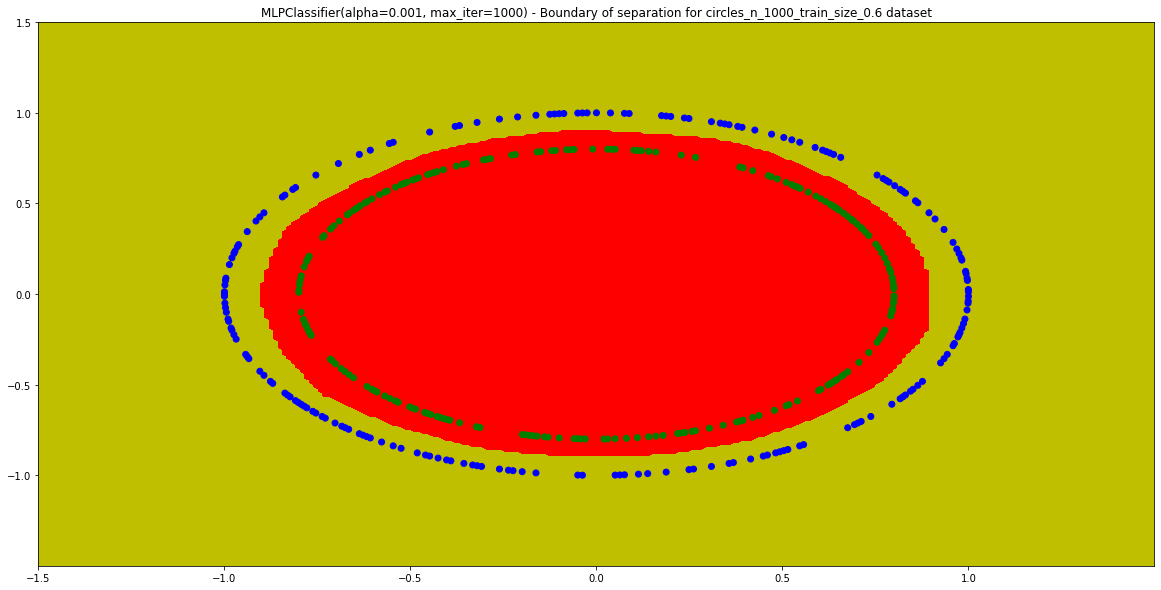


Time of fitting on circles_n_1000_train_size_0.6 for MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False): 29.352617979049683s
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) prediction for train data: 0.003572225570678711s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) for train:
	Accuracy: 0.51
	F1: 0.0
	AUC: 0.5
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) prediction for test data: 0.002998828887939453s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) for test:
	Accuracy: 0.485
	F1: 0.0
	AUC: 0.5


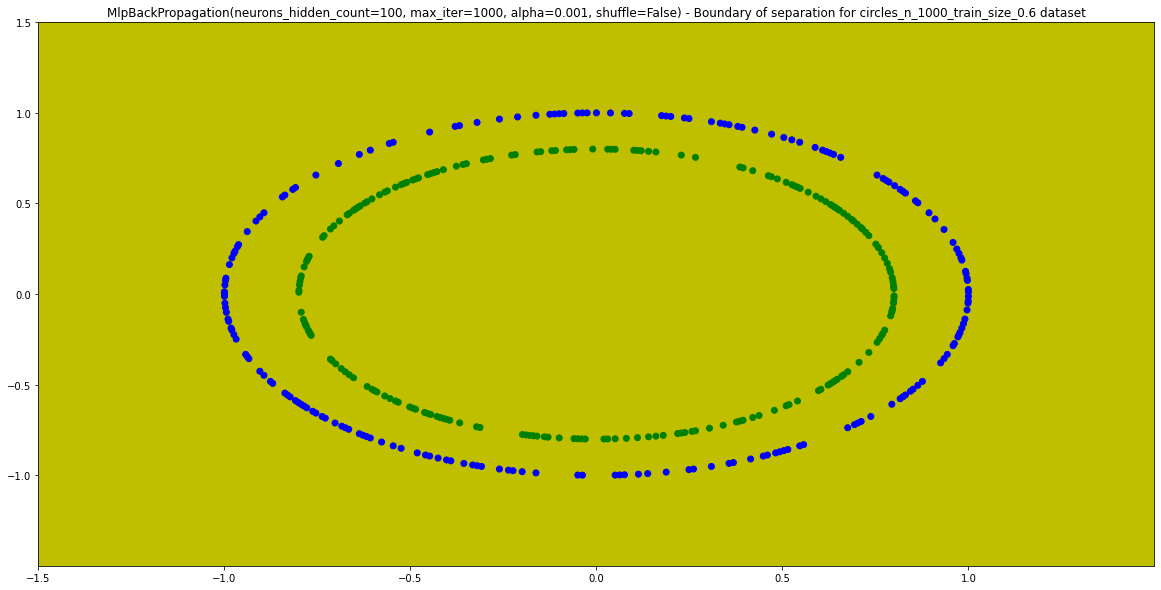


Time of fitting on circles_n_1000_train_size_0.6 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100): 0.046633005142211914s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for train data: 0.0009987354278564453s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for test data: 0.0009996891021728516s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


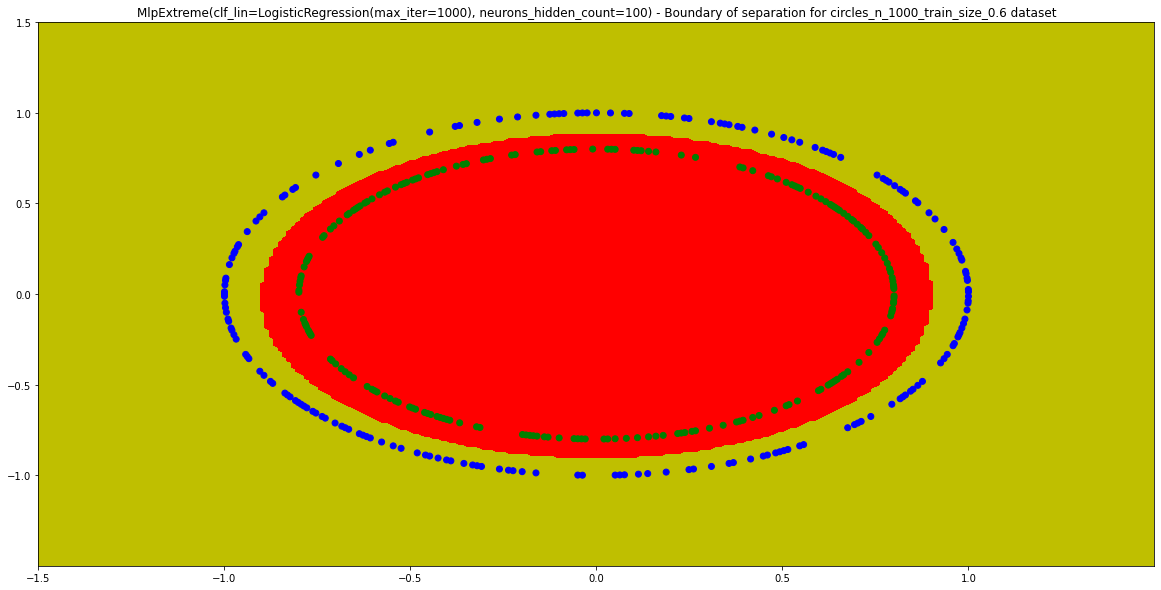


Time of fitting on circles_n_1000_train_size_0.6 for MLPClassifier(alpha=0.01, max_iter=1000): 1.8911457061767578s
Time of MLPClassifier(alpha=0.01, max_iter=1000) prediction for train data: 0.0010008811950683594s
Metrics of MLPClassifier(alpha=0.01, max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.01, max_iter=1000) prediction for test data: 0.0s
Metrics of MLPClassifier(alpha=0.01, max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


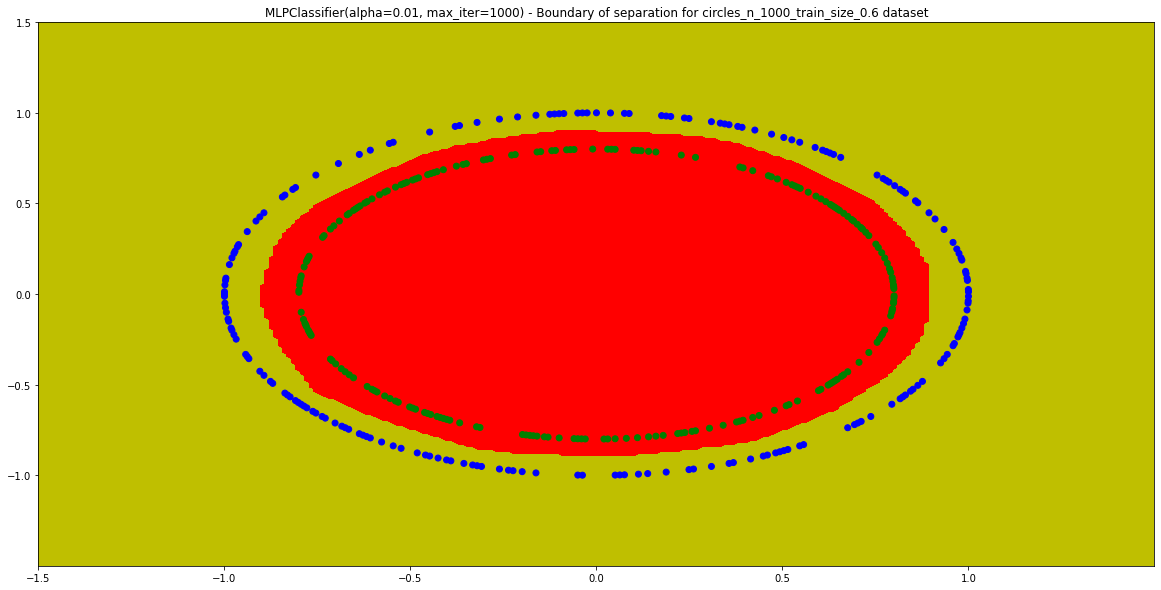


Time of fitting on circles_n_1000_train_size_0.6 for MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False): 28.966989040374756s
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) prediction for train data: 0.004002571105957031s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) for train:
	Accuracy: 0.51
	F1: 0.0
	AUC: 0.5
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) prediction for test data: 0.0020020008087158203s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) for test:
	Accuracy: 0.485
	F1: 0.0
	AUC: 0.5


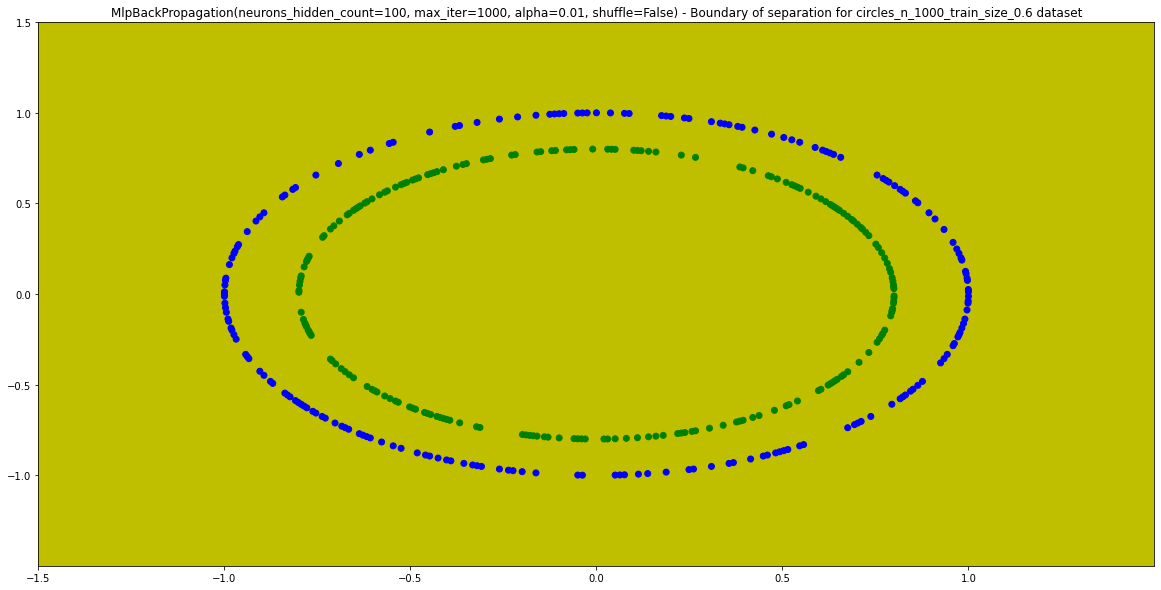


Time of fitting on circles_n_1000_train_size_0.6 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100): 0.04730629920959473s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for train data: 0.0009982585906982422s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for test data: 0.0010008811950683594s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


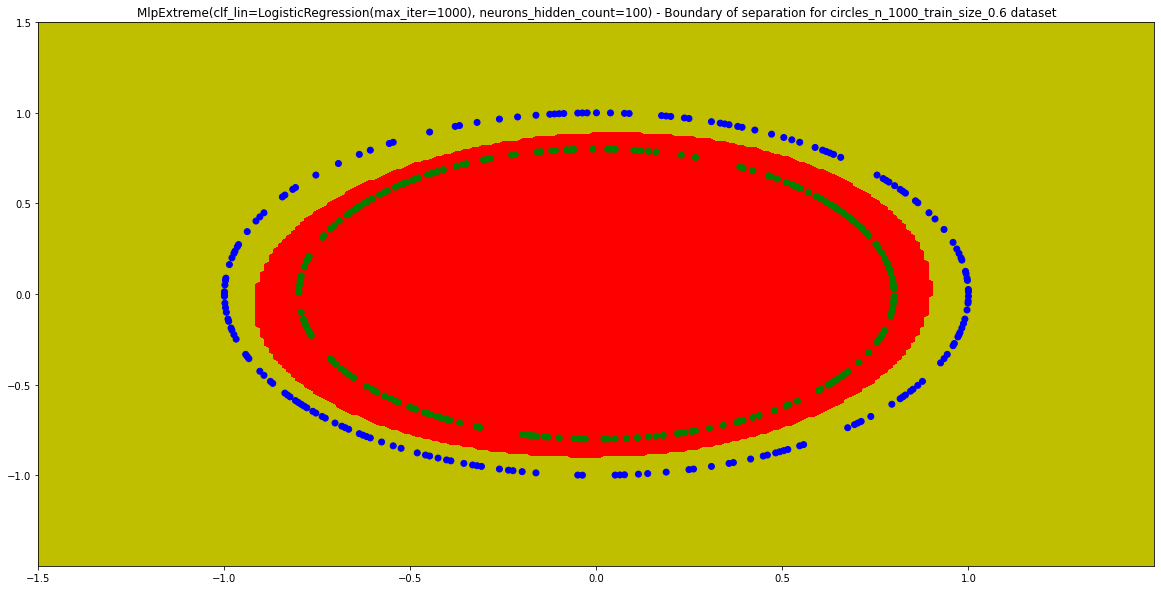


Time of fitting on circles_n_1000_train_size_0.8 for MLPClassifier(alpha=0.001, max_iter=1000): 2.2512052059173584s
Time of MLPClassifier(alpha=0.001, max_iter=1000) prediction for train data: 0.001005411148071289s
Metrics of MLPClassifier(alpha=0.001, max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, max_iter=1000) prediction for test data: 0.0009925365447998047s
Metrics of MLPClassifier(alpha=0.001, max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


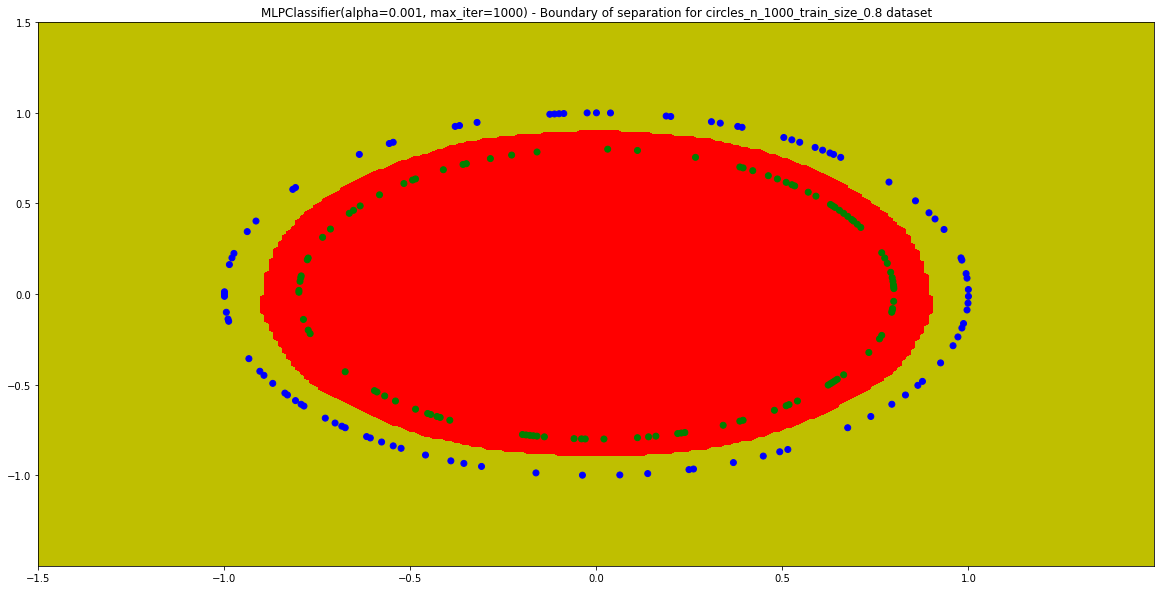


Time of fitting on circles_n_1000_train_size_0.8 for MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False): 35.51518630981445s
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) prediction for train data: 0.0030105113983154297s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) prediction for test data: 0.0010001659393310547s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.001, shuffle=False) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


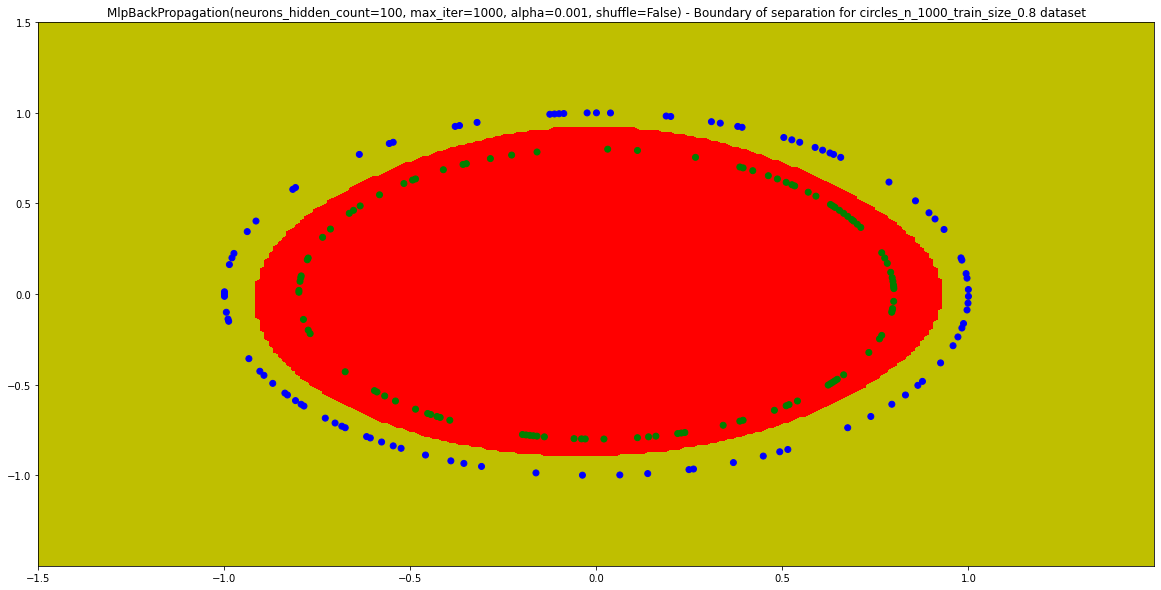


Time of fitting on circles_n_1000_train_size_0.8 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100): 0.040941715240478516s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for train data: 0.0019979476928710938s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for test data: 0.0010309219360351562s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


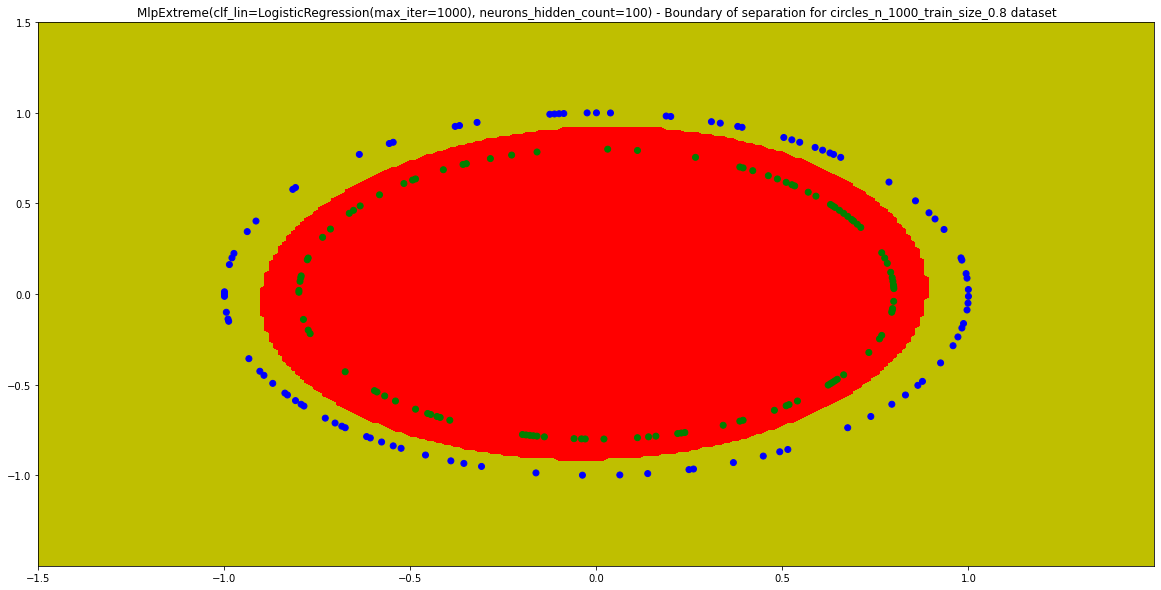


Time of fitting on circles_n_1000_train_size_0.8 for MLPClassifier(alpha=0.01, max_iter=1000): 1.9703352451324463s
Time of MLPClassifier(alpha=0.01, max_iter=1000) prediction for train data: 0.0010046958923339844s
Metrics of MLPClassifier(alpha=0.01, max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.01, max_iter=1000) prediction for test data: 0.0010018348693847656s
Metrics of MLPClassifier(alpha=0.01, max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


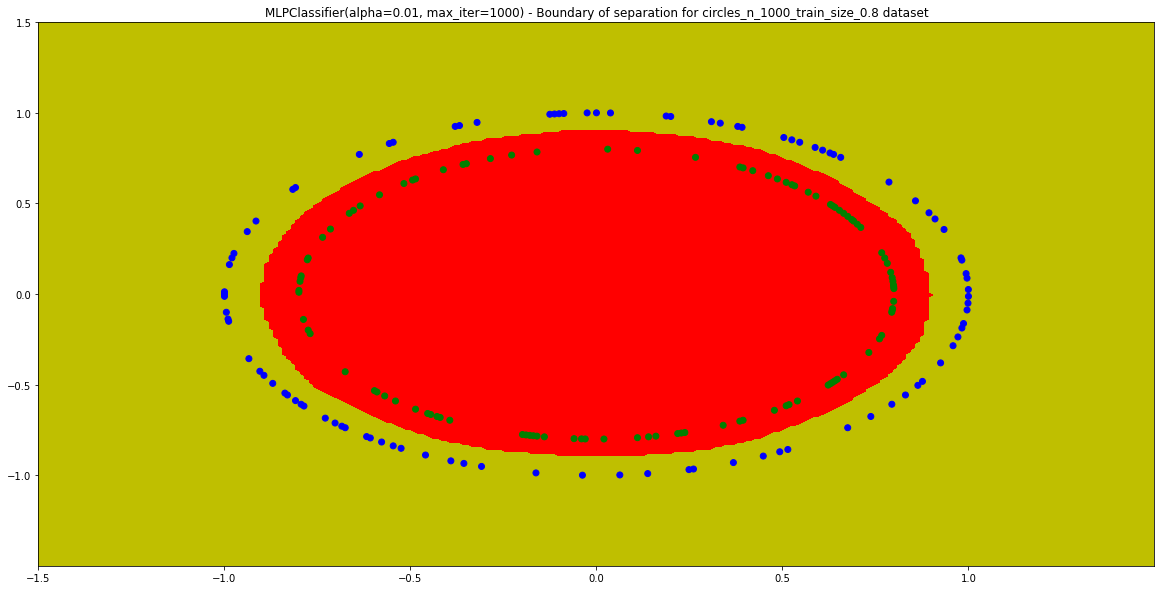


Time of fitting on circles_n_1000_train_size_0.8 for MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False): 36.6193265914917s
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) prediction for train data: 0.00489354133605957s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) prediction for test data: 0.0009894371032714844s
Metrics of MlpBackPropagation(neurons_hidden_count=100, max_iter=1000, alpha=0.01, shuffle=False) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


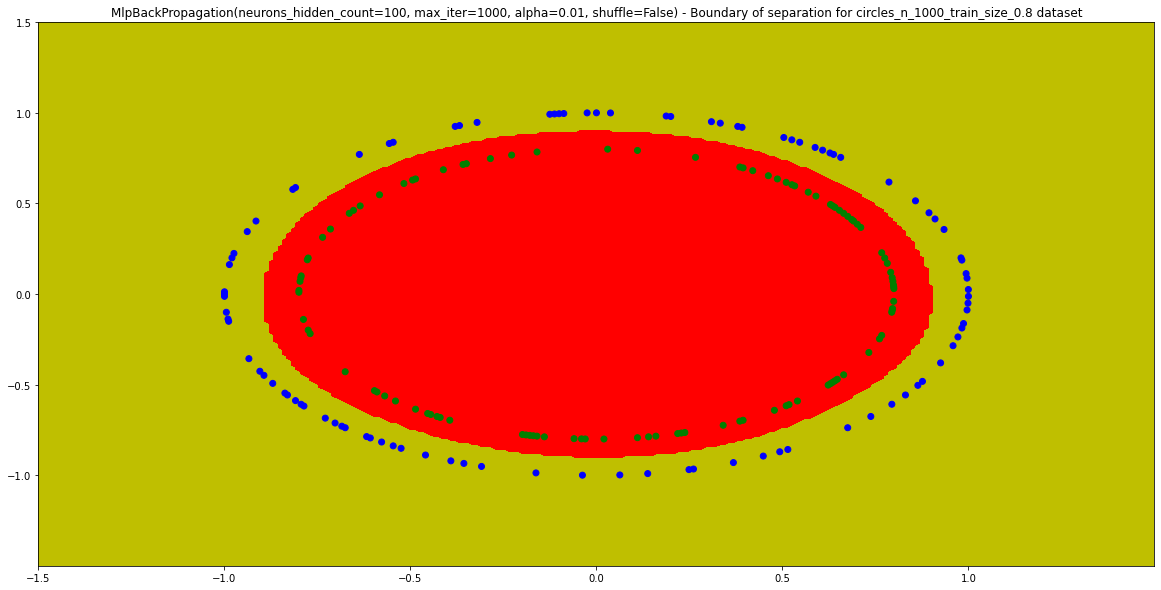


Time of fitting on circles_n_1000_train_size_0.8 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100): 0.04363512992858887s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for train data: 0.0009999275207519531s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) prediction for test data: 0.0010006427764892578s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=100) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


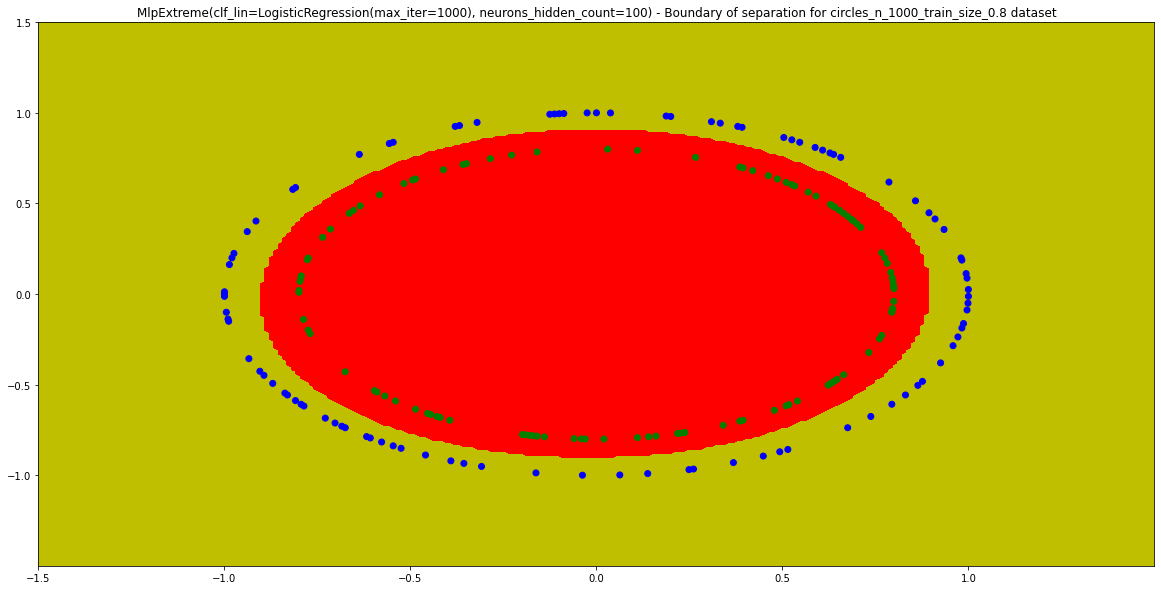


Time of fitting on circles_n_1000_train_size_0.5 for MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000): 2.3421692848205566s
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) prediction for train data: 0.0015552043914794922s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) prediction for test data: 0.0009922981262207031s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


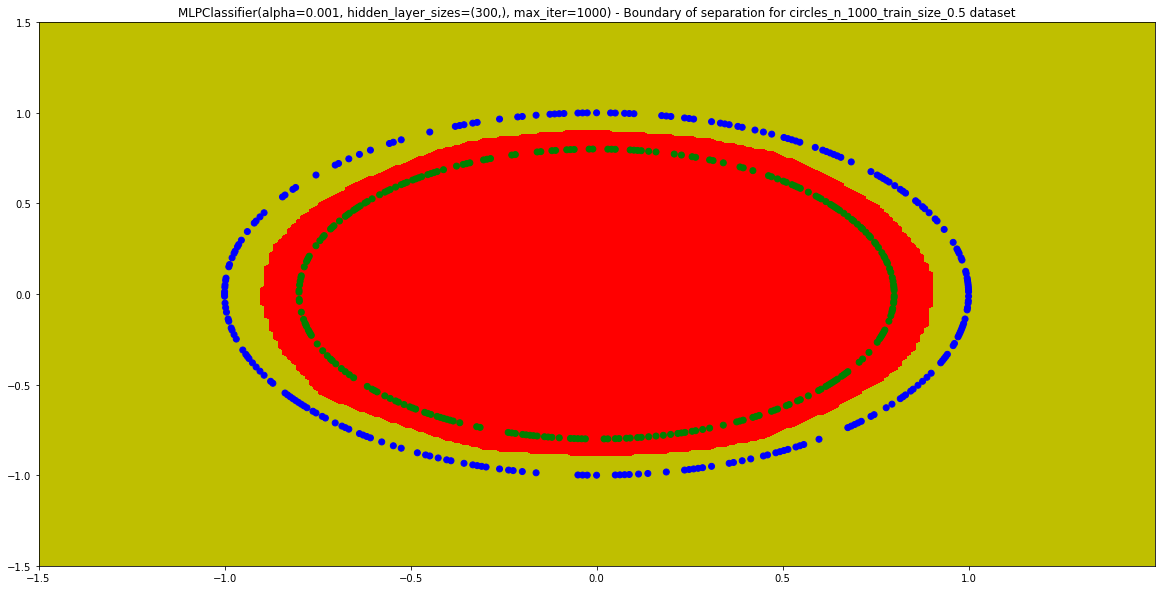


Time of fitting on circles_n_1000_train_size_0.5 for MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False): 28.103493452072144s
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) prediction for train data: 0.00601506233215332s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) for train:
	Accuracy: 0.49
	F1: 0.6577181208053691
	AUC: 0.5
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) prediction for test data: 0.005002260208129883s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) for test:
	Accuracy: 0.51
	F1: 0.6754966887417219
	AUC: 0.5


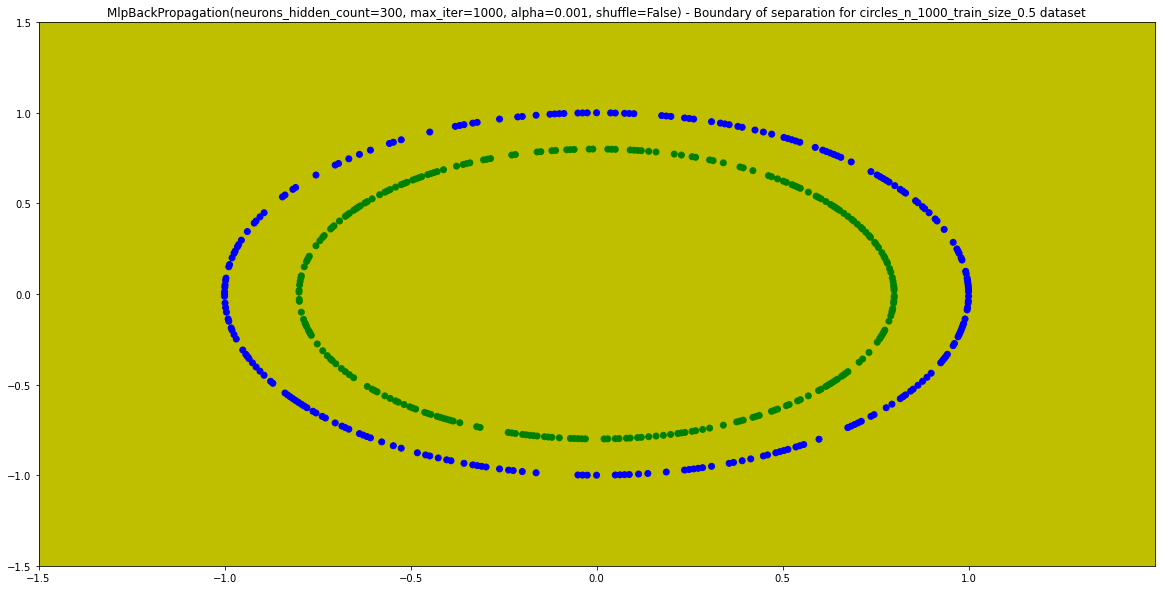


Time of fitting on circles_n_1000_train_size_0.5 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300): 0.06099987030029297s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for train data: 0.004999876022338867s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for test data: 0.00501561164855957s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


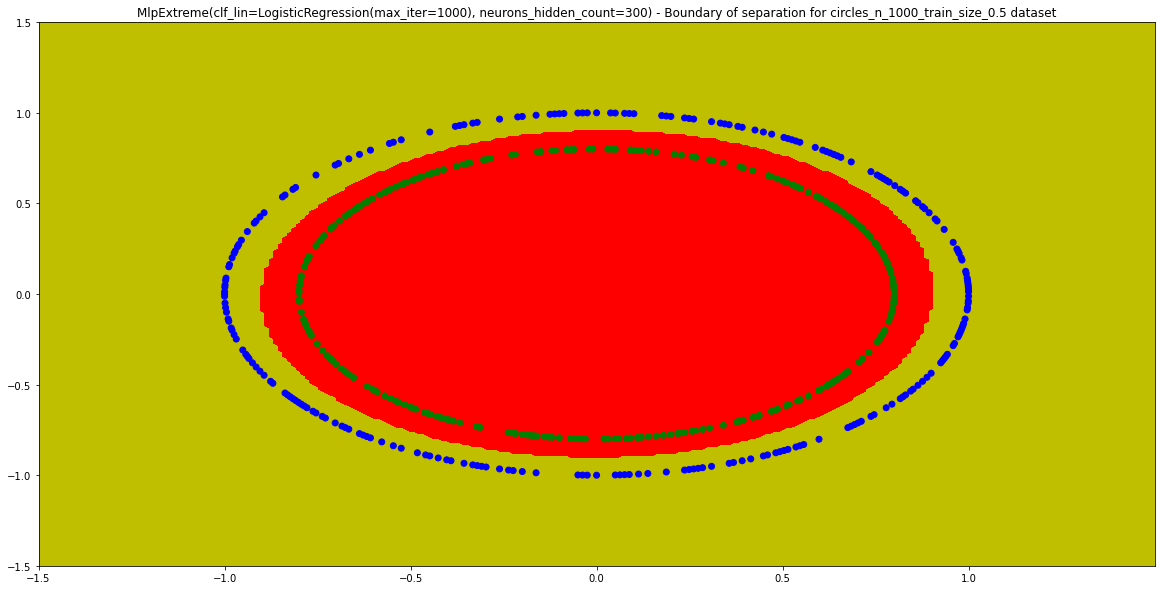


Time of fitting on circles_n_1000_train_size_0.5 for MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000): 1.9235179424285889s
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) prediction for train data: 0.0009996891021728516s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) prediction for test data: 0.0009958744049072266s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


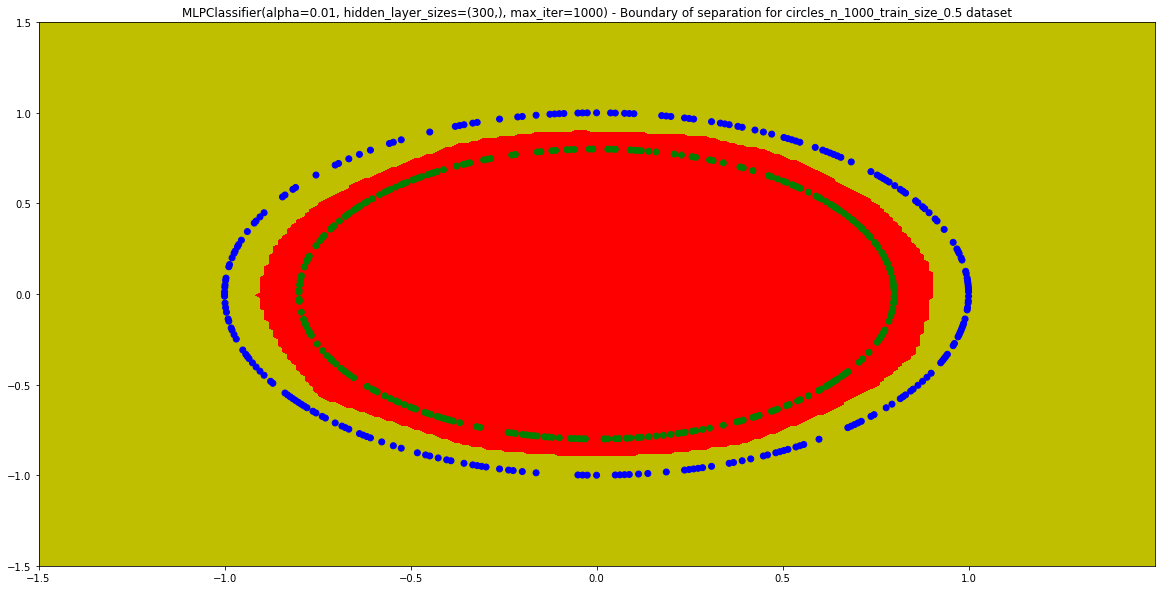


Time of fitting on circles_n_1000_train_size_0.5 for MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False): 27.438953161239624s
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) prediction for train data: 0.005997657775878906s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) prediction for test data: 0.006014823913574219s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


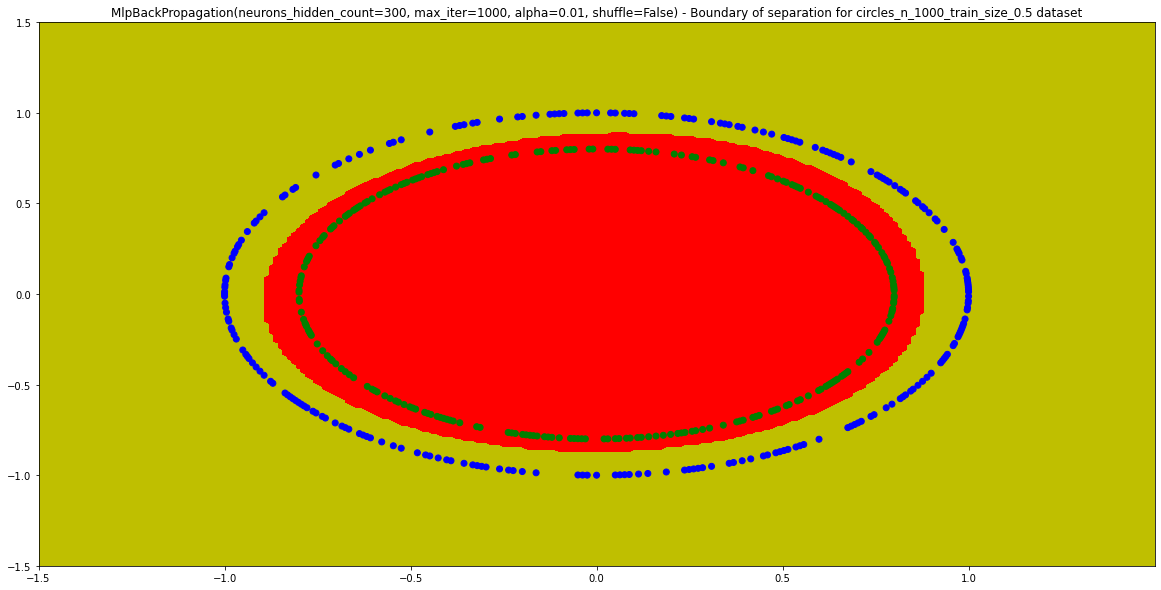


Time of fitting on circles_n_1000_train_size_0.5 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300): 0.060616254806518555s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for train data: 0.0050122737884521484s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for test data: 0.004994630813598633s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


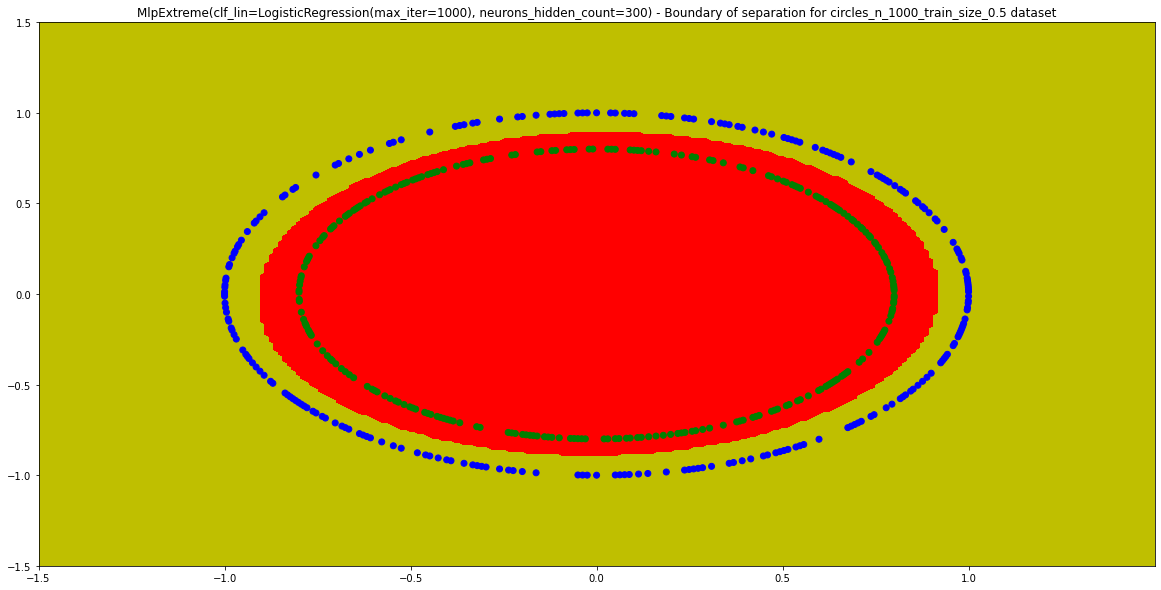


Time of fitting on circles_n_1000_train_size_0.6 for MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000): 2.1149888038635254s
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) prediction for train data: 0.0010137557983398438s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) prediction for test data: 0.0s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


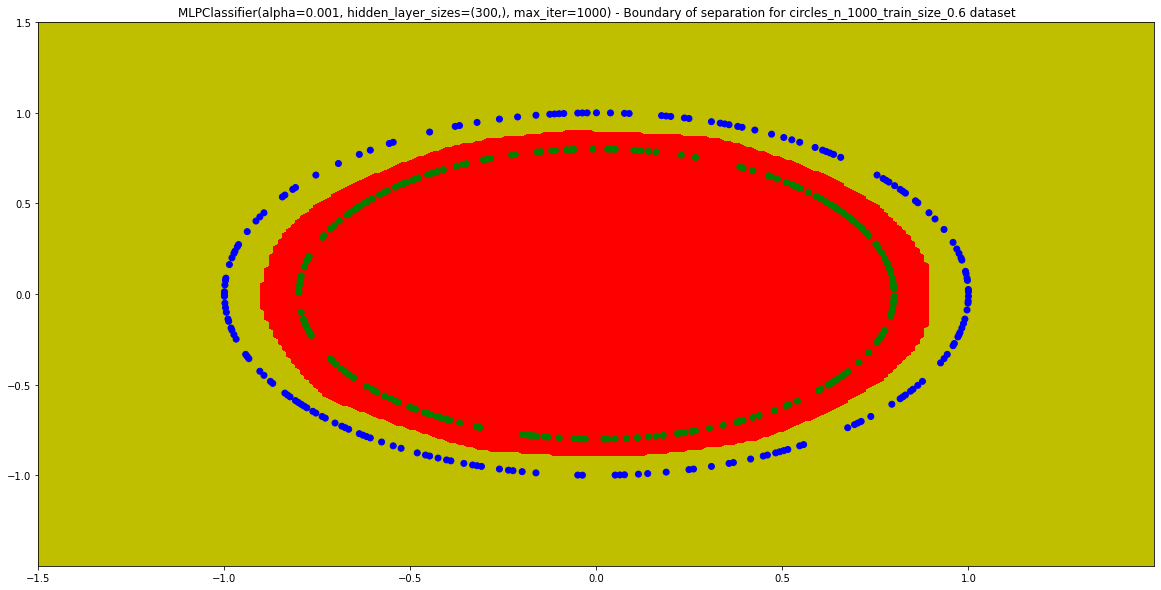


Time of fitting on circles_n_1000_train_size_0.6 for MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False): 34.13716006278992s
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) prediction for train data: 0.007132768630981445s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) for train:
	Accuracy: 0.51
	F1: 0.0
	AUC: 0.5
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) prediction for test data: 0.0040318965911865234s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) for test:
	Accuracy: 0.485
	F1: 0.0
	AUC: 0.5


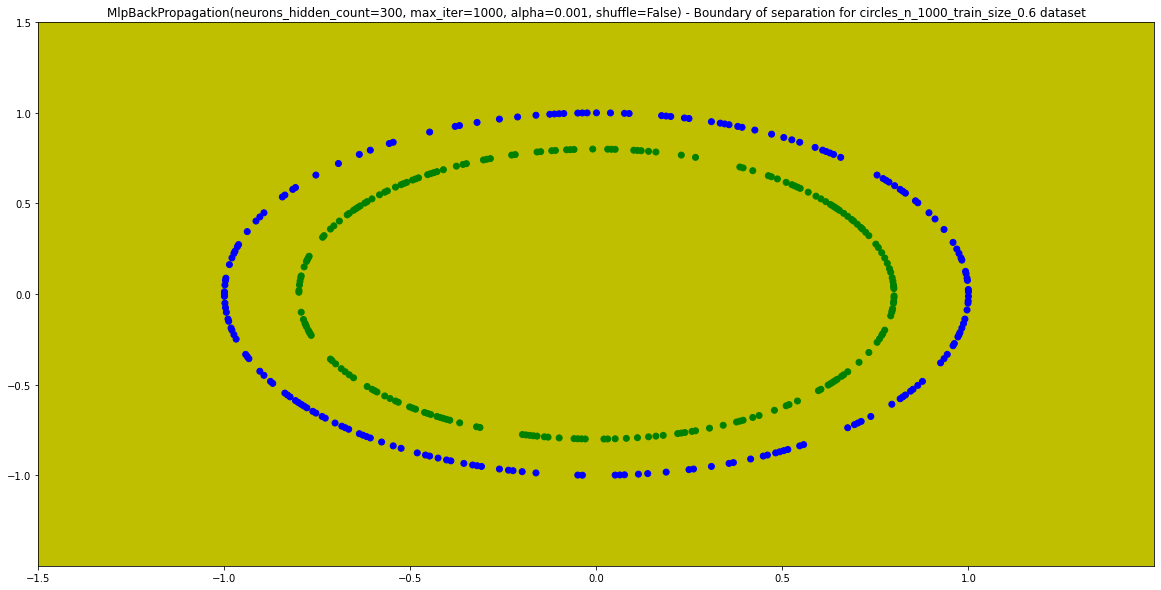


Time of fitting on circles_n_1000_train_size_0.6 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300): 0.05765938758850098s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for train data: 0.006071805953979492s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for test data: 0.0030100345611572266s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


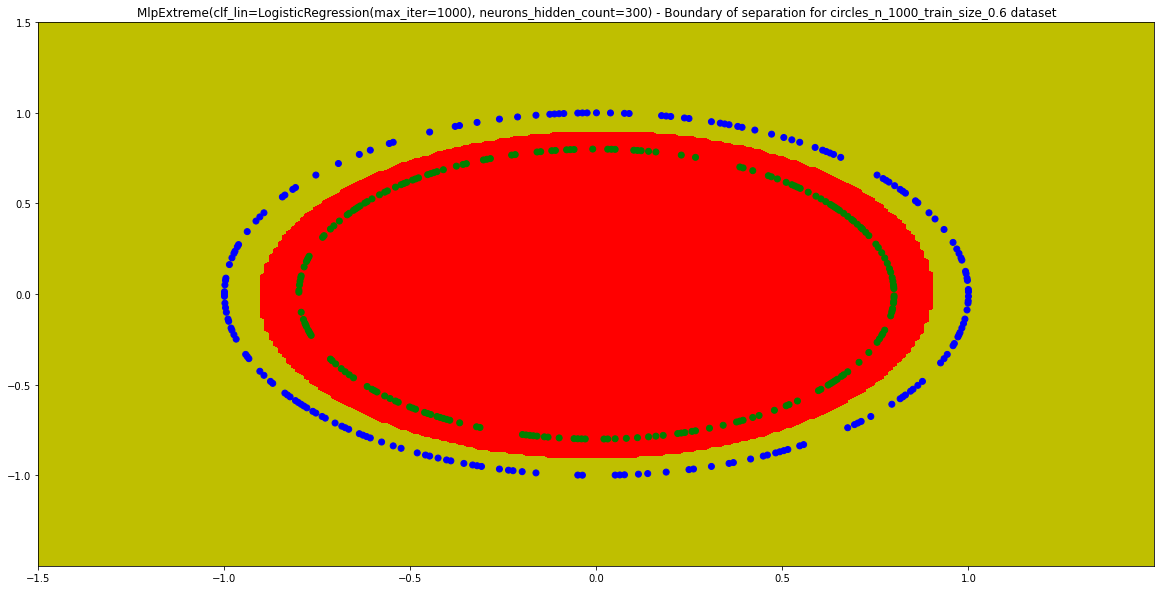


Time of fitting on circles_n_1000_train_size_0.6 for MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000): 2.0050058364868164s
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) prediction for train data: 0.0009911060333251953s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) prediction for test data: 0.0009996891021728516s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


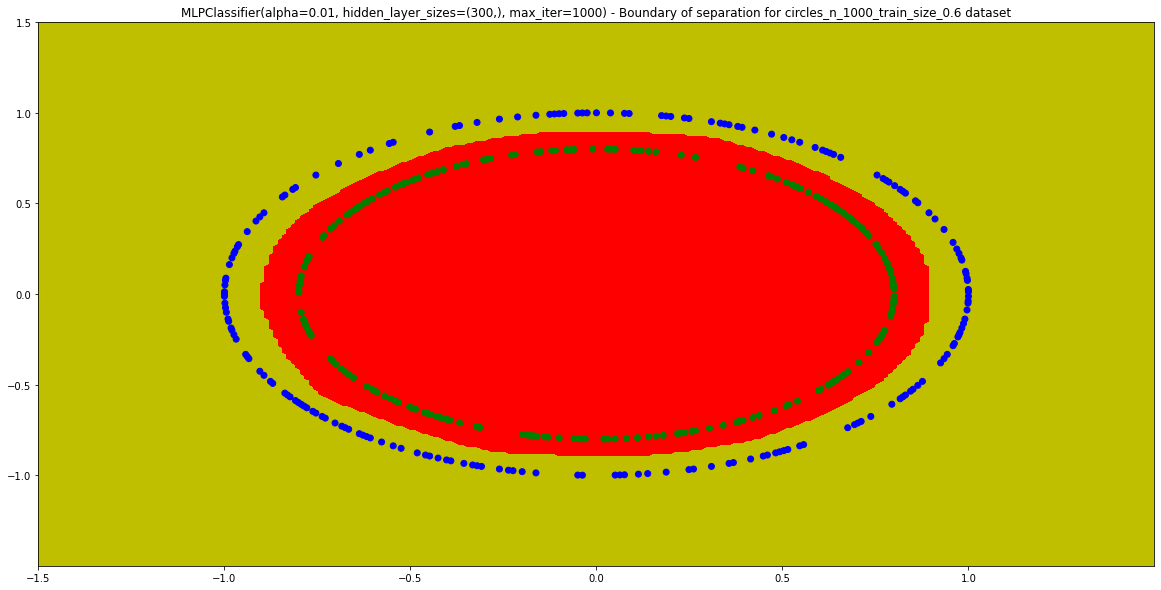


Time of fitting on circles_n_1000_train_size_0.6 for MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False): 33.432177782058716s
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) prediction for train data: 0.007020711898803711s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) for train:
	Accuracy: 0.51
	F1: 0.0
	AUC: 0.5
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) prediction for test data: 0.004027128219604492s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) for test:
	Accuracy: 0.485
	F1: 0.0
	AUC: 0.5


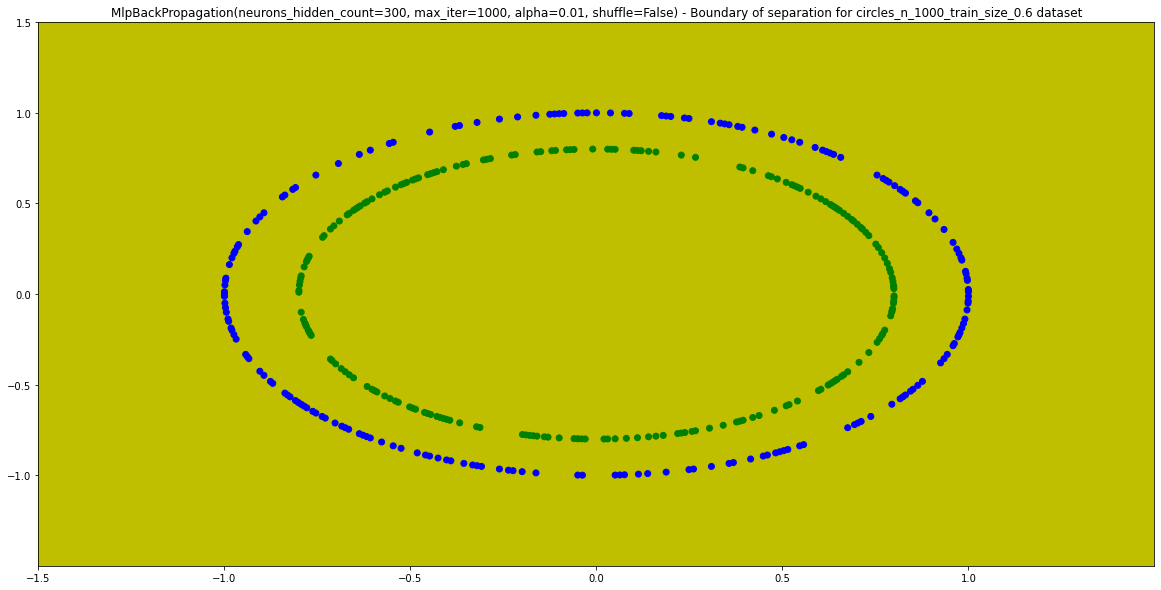


Time of fitting on circles_n_1000_train_size_0.6 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300): 0.0758659839630127s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for train data: 0.005603313446044922s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for test data: 0.0029981136322021484s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


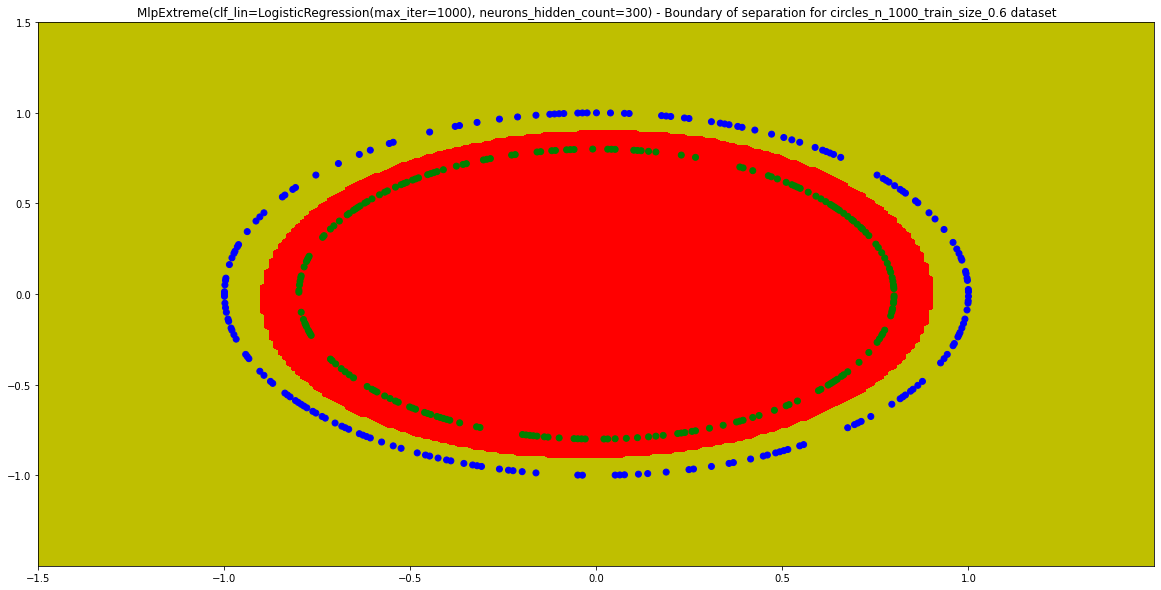


Time of fitting on circles_n_1000_train_size_0.8 for MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000): 2.2670493125915527s
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) prediction for train data: 0.0012564659118652344s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) prediction for test data: 0.0009987354278564453s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(300,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


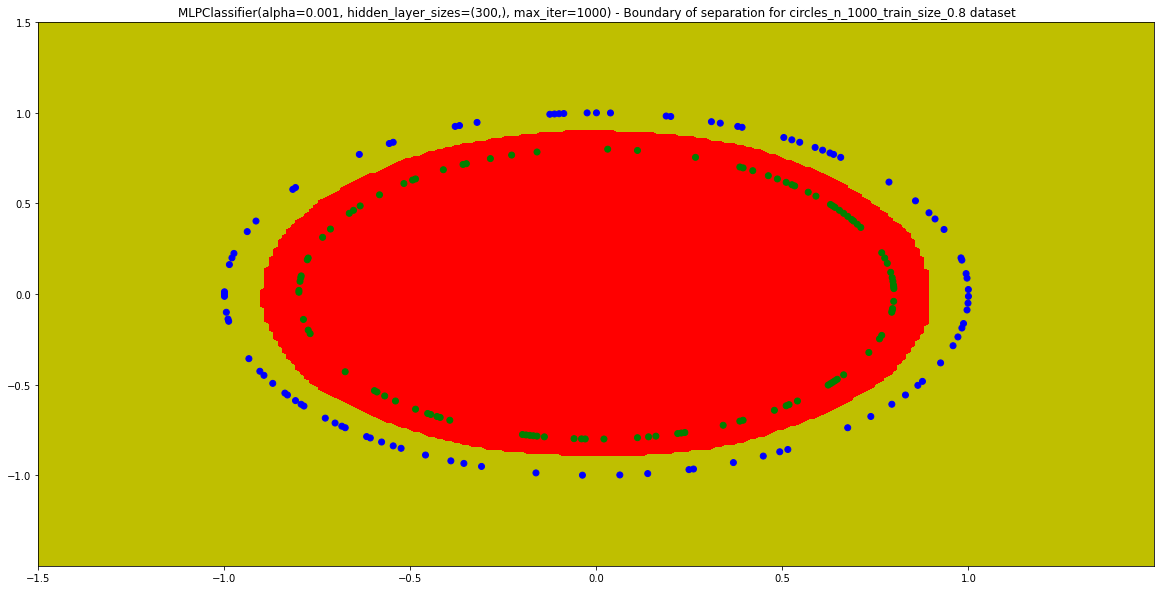


Time of fitting on circles_n_1000_train_size_0.8 for MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False): 45.17115259170532s
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) prediction for train data: 0.008991718292236328s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) for train:
	Accuracy: 0.505
	F1: 0.0
	AUC: 0.5
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) prediction for test data: 0.0020885467529296875s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.001, shuffle=False) for test:
	Accuracy: 0.48
	F1: 0.0
	AUC: 0.5


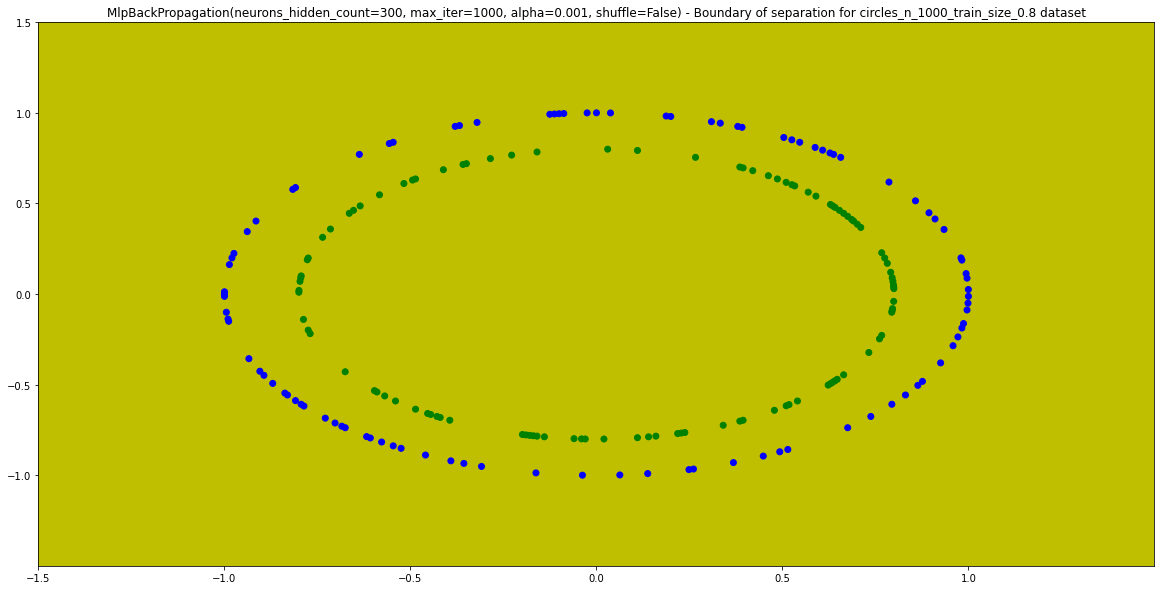


Time of fitting on circles_n_1000_train_size_0.8 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300): 0.08277559280395508s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for train data: 0.006029605865478516s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for test data: 0.001001596450805664s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


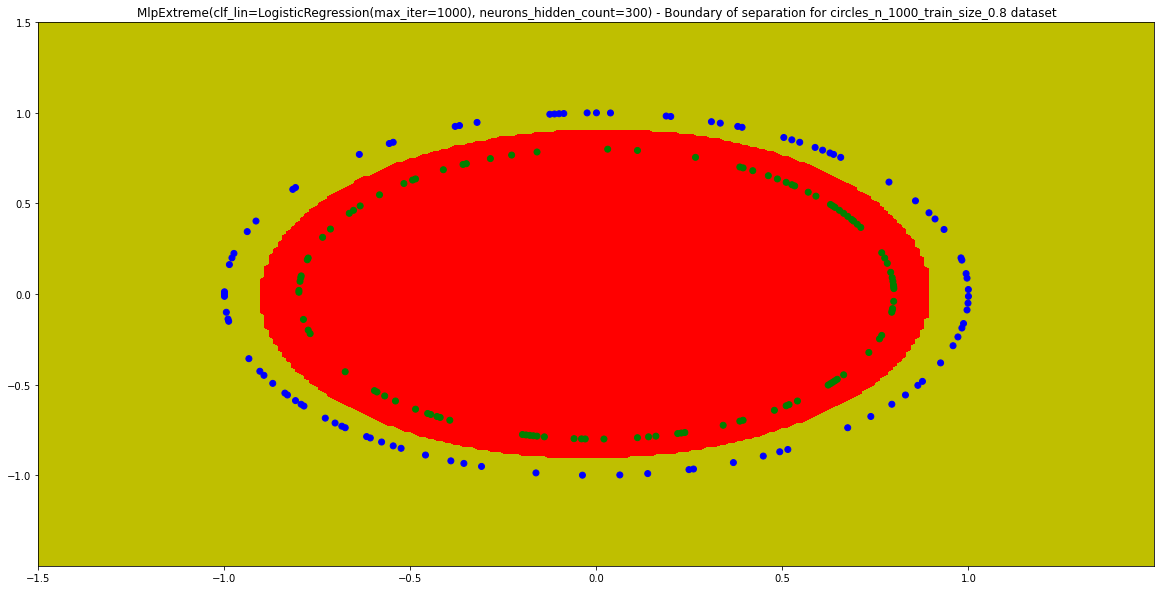


Time of fitting on circles_n_1000_train_size_0.8 for MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000): 2.3312668800354004s
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) prediction for train data: 0.0011429786682128906s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) prediction for test data: 0.0010027885437011719s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(300,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


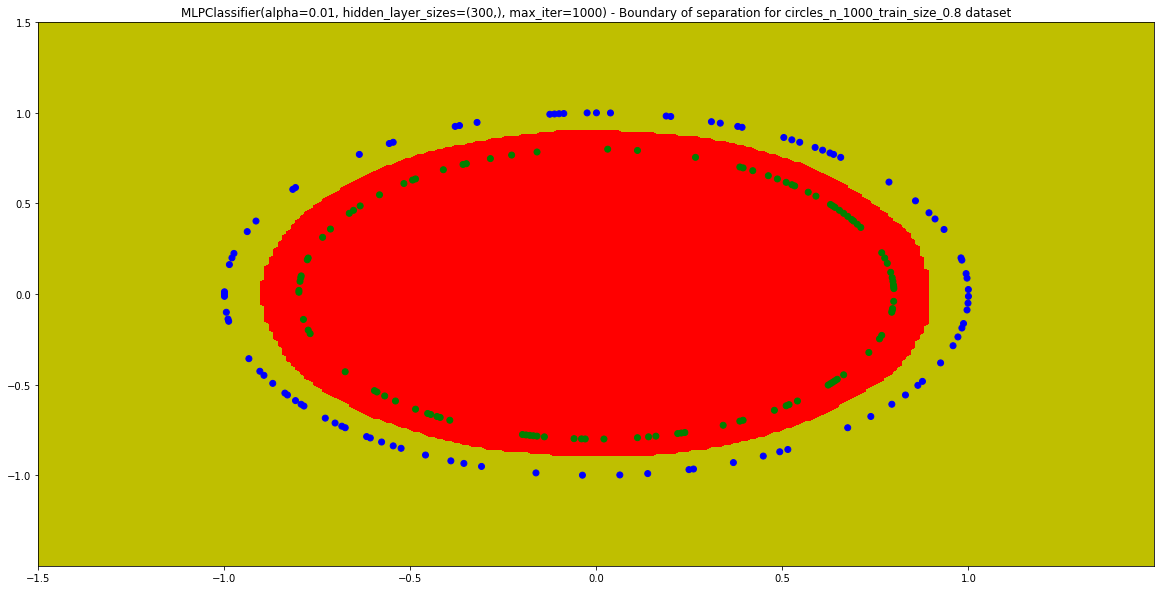


Time of fitting on circles_n_1000_train_size_0.8 for MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False): 43.99194407463074s
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) prediction for train data: 0.00903630256652832s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) prediction for test data: 0.002001047134399414s
Metrics of MlpBackPropagation(neurons_hidden_count=300, max_iter=1000, alpha=0.01, shuffle=False) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


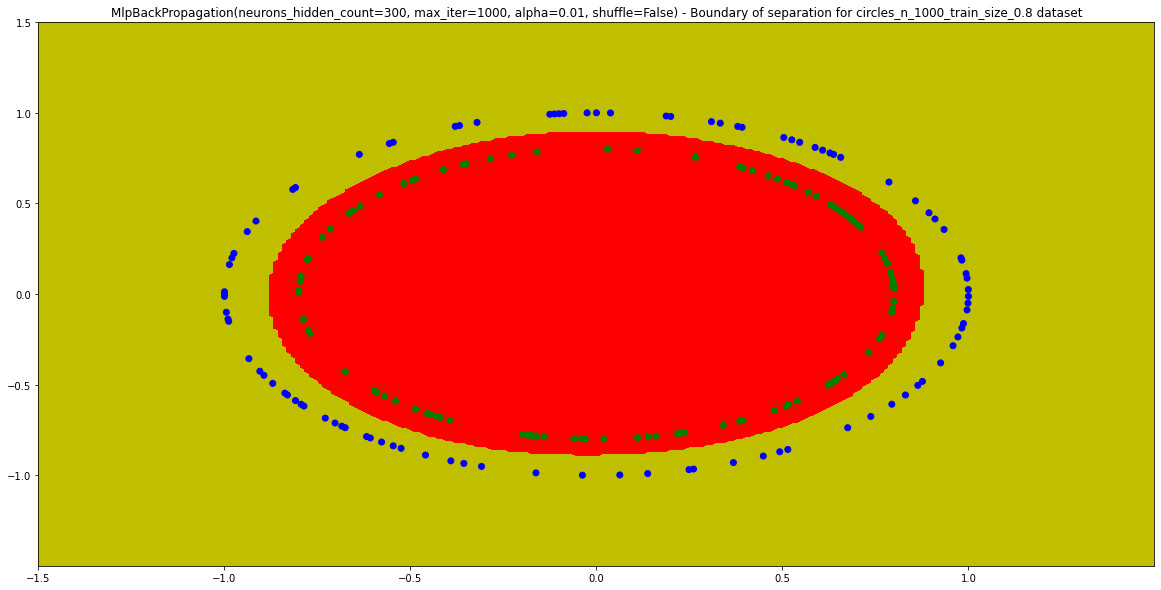


Time of fitting on circles_n_1000_train_size_0.8 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300): 0.0772402286529541s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for train data: 0.007014751434326172s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) prediction for test data: 0.0020186901092529297s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=300) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


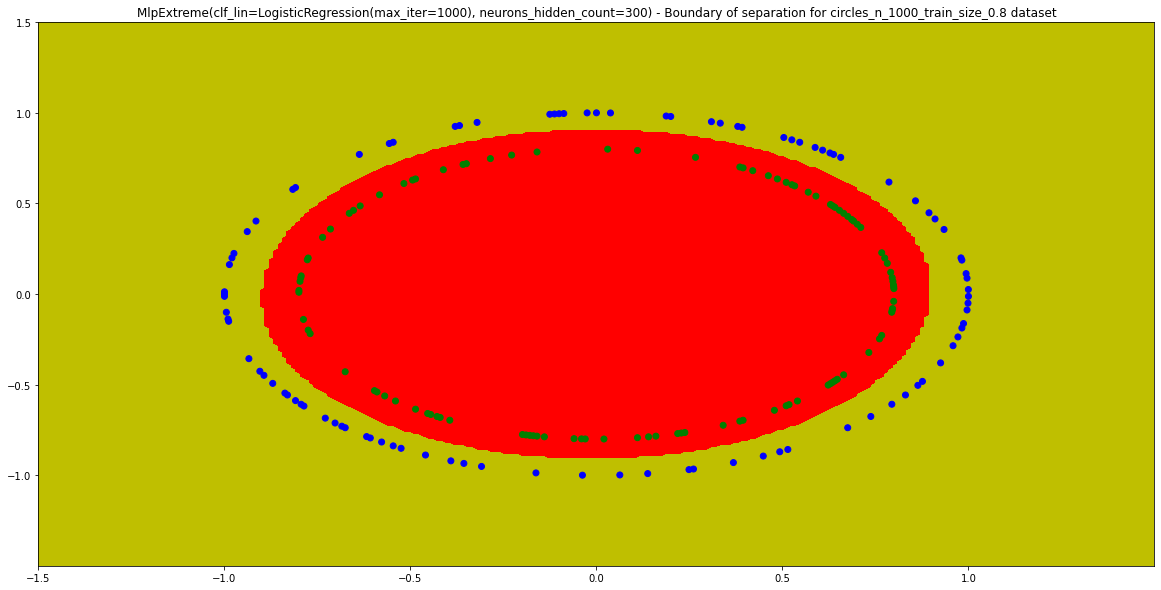


Time of fitting on circles_n_1000_train_size_0.5 for MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000): 4.007991552352905s
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) prediction for train data: 0.004000186920166016s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) prediction for test data: 0.003010272979736328s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


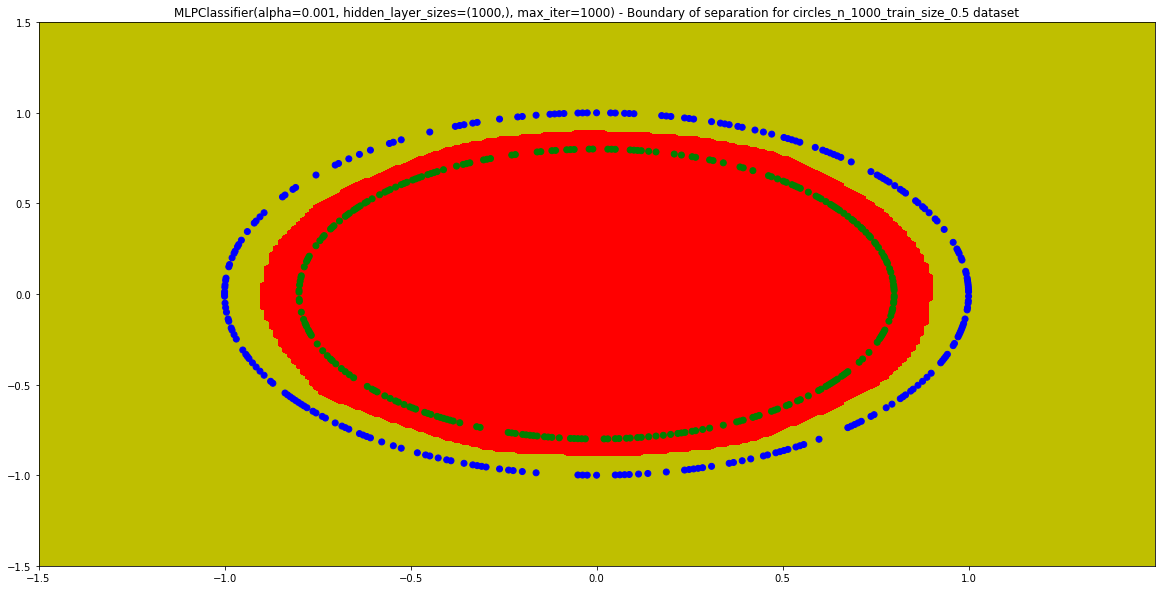


Time of fitting on circles_n_1000_train_size_0.5 for MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.001, shuffle=False): 43.011494398117065s
Time of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.001, shuffle=False) prediction for train data: 0.018369674682617188s
Metrics of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.001, shuffle=False) for train:
	Accuracy: 0.49
	F1: 0.6577181208053691
	AUC: 0.5
Time of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.001, shuffle=False) prediction for test data: 0.015088558197021484s
Metrics of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.001, shuffle=False) for test:
	Accuracy: 0.51
	F1: 0.6754966887417219
	AUC: 0.5


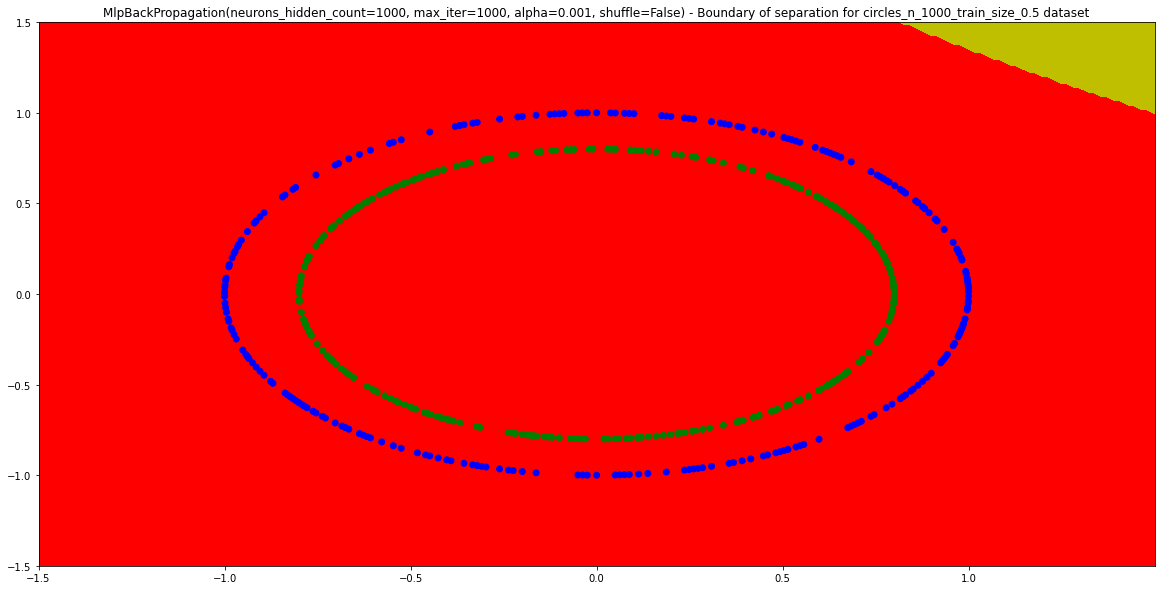


Time of fitting on circles_n_1000_train_size_0.5 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000): 0.19638729095458984s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) prediction for train data: 0.014852285385131836s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) prediction for test data: 0.014631032943725586s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


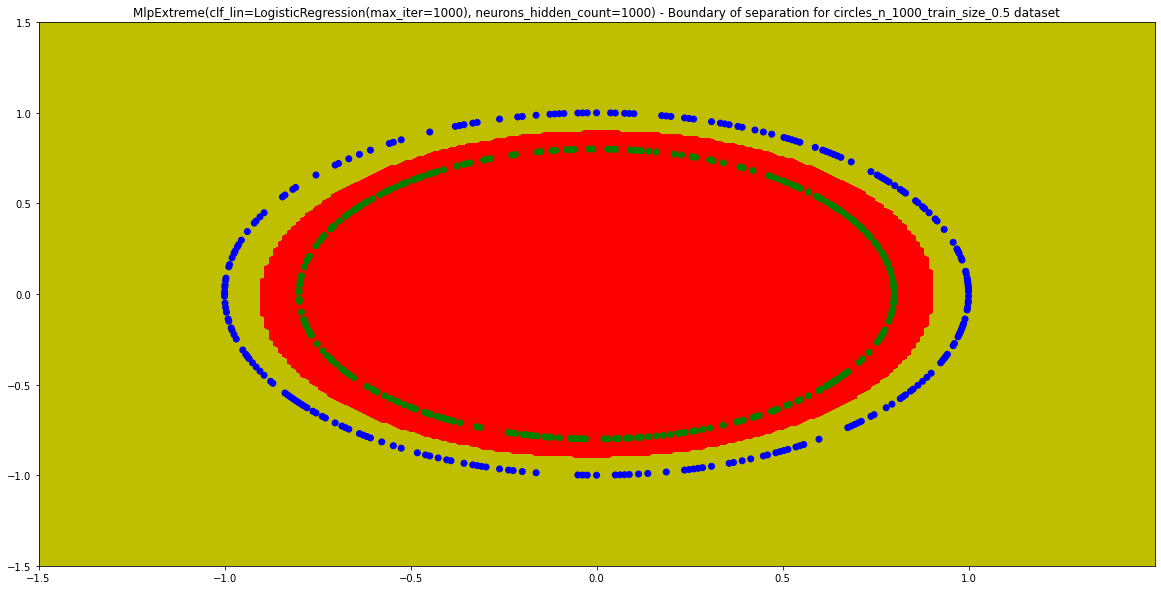


Time of fitting on circles_n_1000_train_size_0.5 for MLPClassifier(alpha=0.01, hidden_layer_sizes=(1000,), max_iter=1000): 3.8847458362579346s
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(1000,), max_iter=1000) prediction for train data: 0.004001140594482422s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(1000,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.01, hidden_layer_sizes=(1000,), max_iter=1000) prediction for test data: 0.0030062198638916016s
Metrics of MLPClassifier(alpha=0.01, hidden_layer_sizes=(1000,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


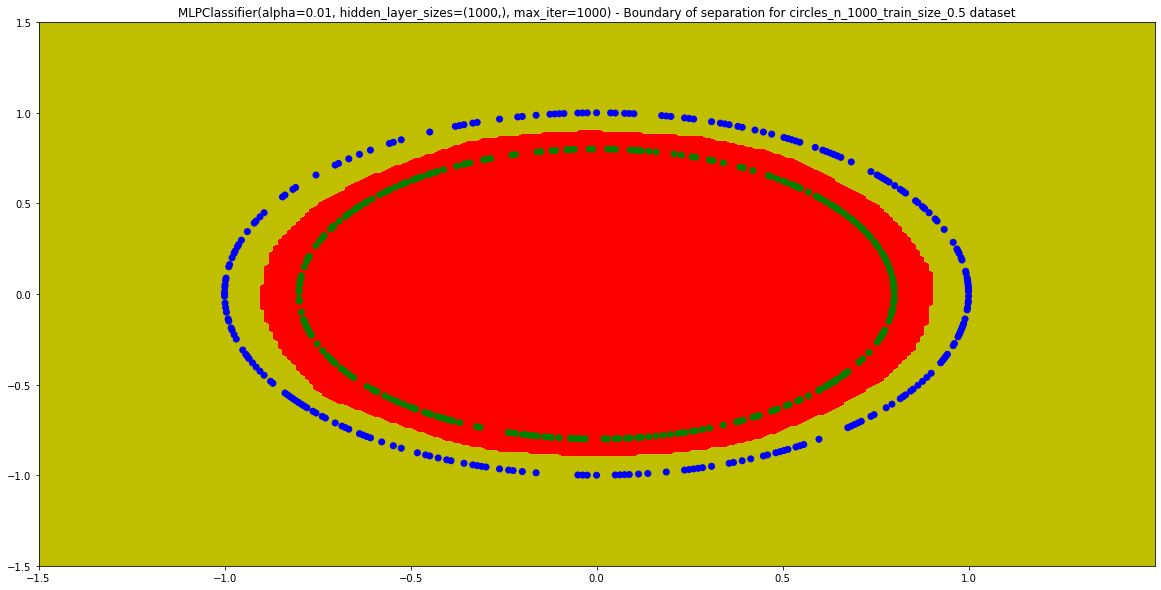


Time of fitting on circles_n_1000_train_size_0.5 for MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.01, shuffle=False): 43.17242217063904s
Time of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.01, shuffle=False) prediction for train data: 0.01353144645690918s
Metrics of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.01, shuffle=False) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.01, shuffle=False) prediction for test data: 0.014096260070800781s
Metrics of MlpBackPropagation(neurons_hidden_count=1000, max_iter=1000, alpha=0.01, shuffle=False) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


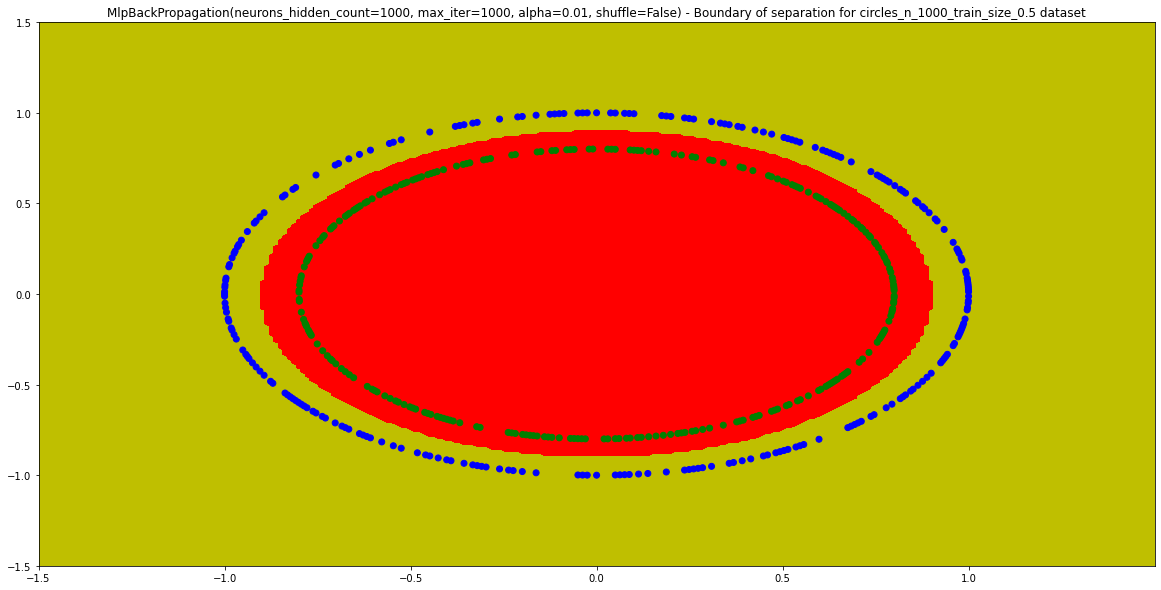


Time of fitting on circles_n_1000_train_size_0.5 for MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000): 0.16472768783569336s
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) prediction for train data: 0.01311945915222168s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) prediction for test data: 0.014115571975708008s
Metrics of MlpExtreme(clf_lin=LogisticRegression(max_iter=1000), neurons_hidden_count=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


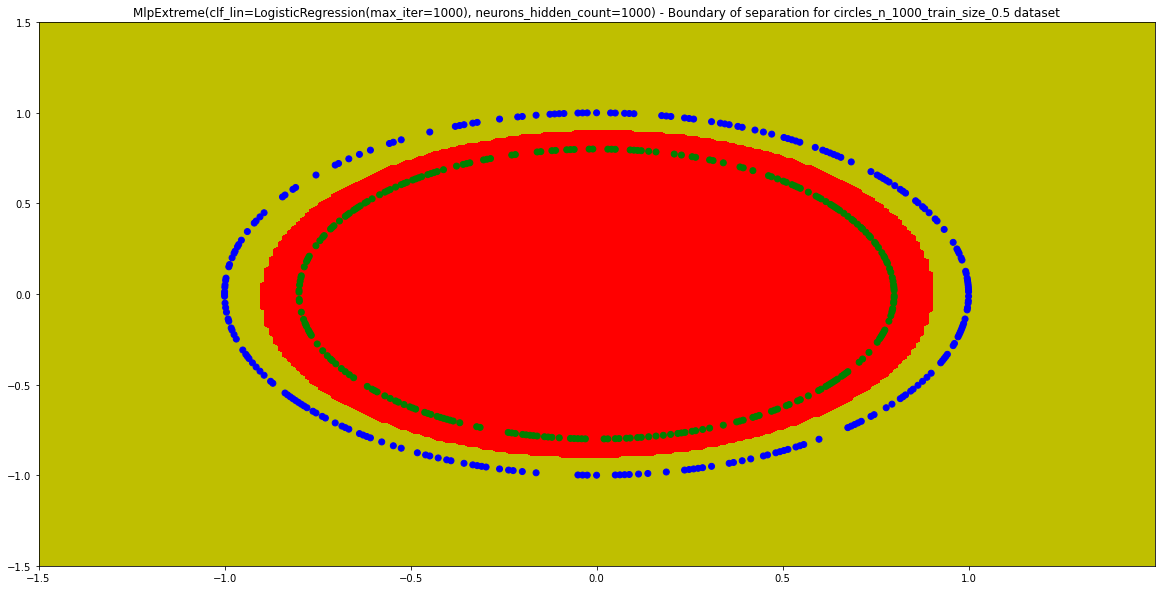


Time of fitting on circles_n_1000_train_size_0.6 for MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000): 4.588295221328735s
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) prediction for train data: 0.00400996208190918s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) for train:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0
Time of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) prediction for test data: 0.002001523971557617s
Metrics of MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000,), max_iter=1000) for test:
	Accuracy: 1.0
	F1: 1.0
	AUC: 1.0


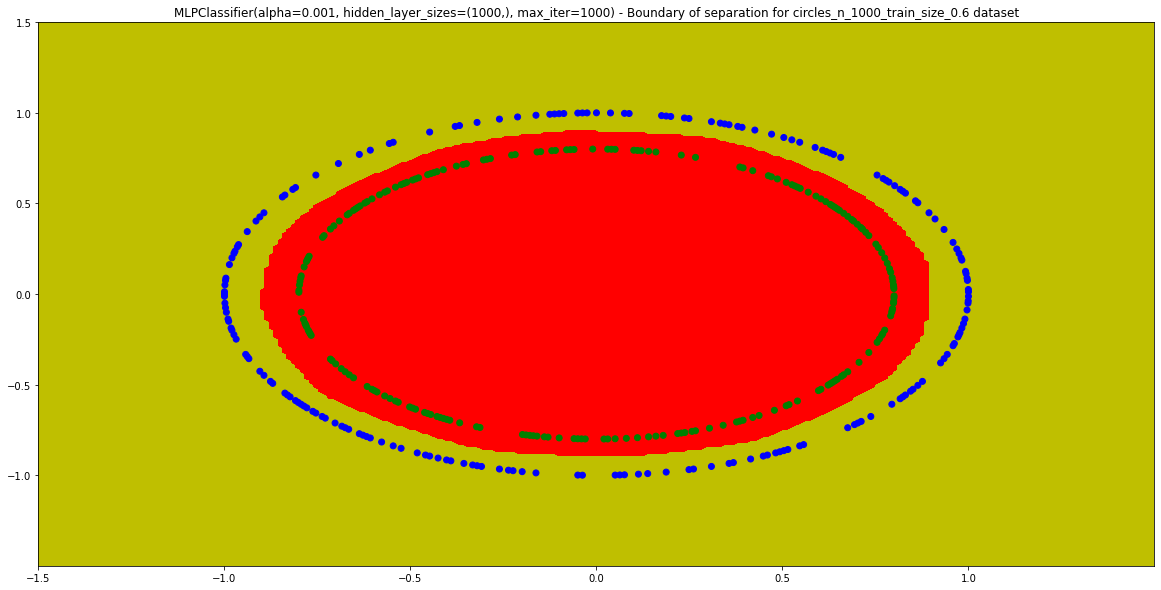

KeyboardInterrupt: 

In [21]:
mlpTest = MlpTest()
mlpTest.experiment()

Zestawienie wyników:

Wnioski:
* ...